In [1]:
import networkx as nx
import random
import copy
from tqdm.notebook import tqdm

## Create

In [2]:
amazon_G = nx.read_graphml('./amazon_graph.graphml')

# Minimizar la distancia entre los nodos dentro de una comunidad
# Maximizar la distancia entre los nodos de disintas comunidades

In [3]:
def create_individuo(nodes_of_graph, adj_matrix, transformation):
    individuo =  [None] * len(nodes_of_graph)
    for i in range(len(nodes_of_graph)): #el individuo creado con el tipo locus tiene la longitud de los nodos

        
        nodo_vecino = random.choice(range(len(adj_matrix[i]))) #la matriz de adyacencia tiene los nodos vecinos, los nodos vecinos hay que convertirlos a numeros
        while adj_matrix[i][nodo_vecino] == 0 and nodo_vecino != i:
            nodo_vecino = random.choice(range(len(adj_matrix[nodo_vecino])))
        
        
        keys = list(transformation.keys())
        values = list(transformation.values())
        individuo[i] = keys[values.index(nodo_vecino)] # en el gen se pone el aleatorio de los vecinos pero transformado en el indice que le corresponde 
    return individuo

def create(nodes_of_graph, adj_matrix, transformation, N=100): # crea población, la transformacion debe de ser del tipo { numero_de_nodo_real : indice_del_array}, donde el indice del array va de 0 a len(nodos) - 1
    new_population = []
    for individuo in range(N):
        new_population.append(create_individuo(nodes_of_graph, adj_matrix, transformation))
    
    return new_population

In [4]:
conversiones = {}
for i, nodo in enumerate(amazon_G.nodes):
    conversiones[nodo] = i
print(conversiones)

{'75780': 0, '317458': 1, '186386': 2, '419862': 3, '176159': 4, '204831': 5, '104481': 6, '57383': 7, '401449': 8, '299055': 9, '176184': 10, '542780': 11, '366654': 12, '124992': 13, '16457': 14, '196682': 15, '546890': 16, '546891': 17, '34895': 18, '321619': 19, '112724': 20, '276567': 21, '55386': 22, '374874': 23, '55388': 24, '221281': 25, '432229': 26, '104553': 27, '383087': 28, '335987': 29, '448649': 30, '522378': 31, '59532': 32, '491667': 33, '518306': 34, '309411': 35, '182435': 36, '204966': 37, '532649': 38, '544939': 39, '542899': 40, '172218': 41, '270524': 42, '250046': 43, '204991': 44, '231620': 45, '497867': 46, '186575': 47, '346322': 48, '399572': 49, '276695': 50, '530647': 51, '18650': 52, '252125': 53, '59613': 54, '127199': 55, '379102': 56, '159972': 57, '366824': 58, '116969': 59, '202986': 60, '430314': 61, '350442': 62, '4328': 63, '458993': 64, '30962': 65, '35067': 66, '57600': 67, '217346': 68, '295177': 69, '49424': 70, '278': 71, '123159': 72, '3218

In [5]:
A = nx.to_numpy_array(amazon_G)

In [6]:
pop = create(amazon_G.nodes, A, conversiones)

## Fitness

In [7]:
def convert_individuo(individuo_raw, conversiones):
    new_individuo = [None] * len(individuo_raw)
    for i in range(len(individuo_raw)):
        new_individuo[i] = conversiones.get(str(individuo_raw[i]))
    
    return new_individuo
def unconvert_individuo(individuo, conversiones):
    individuo_raw =  [None] * len(individuo)
    keys = list(conversiones.keys())
    values = list(conversiones.values())
    for i in range(len(individuo)):
        individuo_raw[i] = keys[values.index(individuo[i])]
    return individuo_raw

def get_comunidades(individuo):

    G = nx.Graph()

    for i in range(len(individuo)):
        G.add_edge(i, individuo[i])

    comunidades = list(nx.connected_components(G))
    return comunidades

def get_cs(aristas_of_min_one_node_in_comunity, nodos_de_la_comunidad):
    cs = 0
    for aristas in aristas_of_min_one_node_in_comunity:
        if aristas[0] in nodos_de_la_comunidad and aristas[1] not in nodos_de_la_comunidad:
            cs += 1
            
        #elif aristas[1] in nodos_de_la_comunidad and aristas[0] not in nodos_de_la_comunidad:
        #    cs += 1
    return cs

def get_ms(aristas_of_min_one_node_in_comunity, nodos_de_la_comunidad):
    ms = 0
    for aristas in aristas_of_min_one_node_in_comunity:
        if aristas[0] in nodos_de_la_comunidad and aristas[1] in nodos_de_la_comunidad:
            ms += 1
            
        
    return ms

In [8]:
def fit_conductance(grafo,individuo,conversiones):
    conductance = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        aristas_of_min_one_node_in_comunity = []
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        for nodo_of_comunity in comunidad_desconvertida:

            aristas_of_min_one_node_in_comunity.append(list(grafo.edges(str(nodo_of_comunity)))[0])
        #aqui ya tenemos las aristas de los nodos para poder sacar el sm
        cs_community = get_cs(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        ms_community = get_ms(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        conductance += cs_community / (2*ms_community + cs_community)
        #
    
    return conductance
        
        
def fit_expansion(grafo,individuo,conversiones):
    expansion = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        aristas_of_min_one_node_in_comunity = []
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        for nodo_of_comunity in comunidad_desconvertida:

            aristas_of_min_one_node_in_comunity.append(list(grafo.edges(str(nodo_of_comunity)))[0])
        #aqui ya tenemos las aristas de los nodos para poder sacar el sm
        cs_community = get_cs(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        ns_community = len(comunidad_desconvertida)
        expansion += cs_community / ns_community
        #
    
    return expansion


def fit_average_odf(grafo,individuo,conversiones):
    average_odf = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        sum_nodos = 0
        for nodo_of_comunity in comunidad_desconvertida:
            aristas_del_nodo = list(grafo.edges(str(nodo_of_comunity)))[0]
            
            sum_nodos += get_cs(aristas_del_nodo,nodo_of_comunity) / len(aristas_del_nodo)
            #aristas_of_min_one_node_in_comunity.append(list(grafo.edges(str(nodo_of_comunity)))[0])
        average_odf += sum_nodos / len(comunidad)
        
        #aqui ya tenemos las aristas de los nodos para poder sacar el sm
        
        #
    
    return average_odf

def fit_Q(grafo,individuo,conversiones):
    Q = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        aristas_of_min_one_node_in_comunity = []
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        n_aristas = 0
        for nodo_of_comunity in comunidad_desconvertida:
            n_aristas += len(list(grafo.edges(str(nodo_of_comunity)))[0])
            aristas_of_min_one_node_in_comunity.append(list(grafo.edges(str(nodo_of_comunity)))[0])
        
        ms_community = get_ms(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        cs_community = get_cs(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        
        Q += ((ms_community/n_aristas) - (((ms_community + cs_community)/(2*n_aristas))**2))
    
    return Q

## Select, Mutate y Crossover

In [9]:
# def select (pop, fits, T): # devuelve un individuo seleccionado por torneo, devuelve una copia para evitar efectos laterales
#     seleccionados = random.sample(pop, T) #los 3 aleatorios
#     for i, indiv in enumerate(seleccionados):
#         es_dominante = True
#         for j, indiv2 in enumerate(seleccionados): 
#             if i == j:
#                 continue
            
#             if fits[i][0] > fits[j][0] and fits[i][1] > fits[j][1]:
#                 es_dominante = (True and es_dominante)
#             else:
#                 es_dominante = (False and es_dominante)
#         if es_dominante:
#             return indiv
#     return random.choice(seleccionados)

def select (pop, T): # devuelve un individuo seleccionado por torneo, devuelve una copia para evitar efectos laterales
    seleccionados = random.sample(pop, T) #los 3 aleatorios
    return copy.copy(pop[min([pop.index(x) for x in seleccionados])])


In [10]:
def mutate (grafo, ind, pmut, transformation): # la mutación consistirá en cambiar un elemento por otro posible nodo con el que este conectado
    probs = [random.random() for prob in range(len(ind))]
    nuevo_elem = copy.copy(ind)
    adj_matrix = nx.to_numpy_array(grafo)
    for i, probability in enumerate(probs):
      if probability < pmut:
            
        nodo_vecino = random.choice(range(len(adj_matrix[i]))) #la matriz de adyacencia tiene los nodos vecinos, los nodos vecinos hay que convertirlos a numeros
        
        while adj_matrix[i][nodo_vecino] == 0 and nodo_vecino != i:
            nodo_vecino = random.choice(range(len(adj_matrix[nodo_vecino])))
        
        keys = list(transformation.keys())
        values = list(transformation.values())
        nuevo_elem[i] = keys[values.index(nodo_vecino)] # en el gen se pone el aleatorio de los vecinos pero transformado en el indice que le corresponde 
    return nuevo_elem

In [11]:
def crossover (ind1, ind2, pcross, n_puntos = 1):
    copia_in1 = copy.copy(ind1)
    copia_in2 = copy.copy(ind2)
    if random.random() < pcross:
      punto = len(ind1) // (n_puntos+1)
      for i in range(n_puntos):
        index_fin = punto*(i+2)
        index_inicio = punto*(i+1)
        if index_fin < len(ind1):
          aux = copia_in1[index_inicio:index_fin]
          copia_in1[index_inicio:index_fin] = copia_in2[index_inicio:index_fin]
          copia_in2[index_inicio:index_fin] = aux
        else:
          aux = copia_in1[index_inicio:]
          copia_in1[index_inicio:] = copia_in2[index_inicio:]
          copia_in2[index_inicio:] = aux
    return copia_in1, copia_in2

# Evolve

In [12]:
def dominates(individual_A, individual_B, fit1_maximize, fit2_maximize):
    if all(a <= b for a, b in zip(individual_A, individual_B)):
        if any(a < b for a, b in zip(individual_A, individual_B)):
            return True
    return False

def get_pareto_front(pop, fits, fit1_maximize, fit2_maximize):
    pareto_front = []
    pareto_fits = []
    for i, fit in enumerate(fits):
        if not any(dominates(fit, fits[j], fit1_maximize, fit2_maximize) for j in range(len(pop)) if i != j):
            pareto_front.append(pop[i])
            pareto_fits.append(fits[i])
    return pareto_front, pareto_fits

Esta funcion añade a la poblacion de la siguiente generacion los individuos restantes para que de el tamaño de la poblacion total

In [13]:
# def get_pareto_fronts(pop, fits):
#     pareto_fronts = []
#     pareto_fits = []

#     remaining_pop = copy.copy(pop)
#     remaining_fits = copy.copy(fits)

#     while remaining_pop:
#         current_pareto, current_fits = get_pareto_front(remaining_pop, remaining_fits)
#         pareto_fronts.append(current_pareto)
#         pareto_fits.append(current_fits)

#         indices_to_remove = [remaining_pop.index(ind) for ind in current_pareto]
#         remaining_pop = [ind for i, ind in enumerate(remaining_pop) if i not in indices_to_remove]
#         remaining_fits = [fit for i, fit in enumerate(remaining_fits) if i not in indices_to_remove]

#     return pareto_fronts, pareto_fits

def sort_pop(pop, fits, fit1_maximize, fit2_maximize):
    pareto_fronts = []
    pareto_fits = []

    remaining_pop = copy.copy(pop)
    remaining_fits = copy.copy(fits)

    while remaining_pop:
        current_pareto, current_fits = get_pareto_front(remaining_pop, remaining_fits, fit1_maximize, fit2_maximize)
        pareto_fronts.extend(current_pareto)
        pareto_fits.extend(current_fits)

        indices_to_remove = [remaining_pop.index(ind) for ind in current_pareto]
        remaining_pop = [ind for i, ind in enumerate(remaining_pop) if i not in indices_to_remove]
        remaining_fits = [fit for i, fit in enumerate(remaining_fits) if i not in indices_to_remove]

    return pareto_fronts, pareto_fits

def select_resto_pop(len_pop, len_pareto_front, pop, fits, T=3):
    num_of_pop_to_fill = len_pop - len_pareto_front
    pop_fill = []
    for _ in range(num_of_pop_to_fill):
        ind = select(pop, fits, T)
        pop_fill.append(ind)
    return pop_fill

In [14]:
import matplotlib.pyplot as plt
def show_progress(pop, fit1, fit2):
    fitness1 = []
    fitness2 = []
    for ind in pop:
        fitness1.append(fit1(amazon_G, ind, conversiones))
        fitness2.append(fit2(amazon_G, ind, conversiones))

    print(f"fit1 : {fitness1}")
    print(f"fit2 : {fitness2}")

    plt.scatter(fitness1, fitness2)
    plt.xlabel('fit_average_odf')
    plt.ylabel('fit_Q')

    plt.show()


In [15]:
def evolve(pop, fit1, fit2, grafo, conversiones, T=3, pcross=0.8, pmut=0.2, n_puntos=1, n_gen=10, fit1_maximize=False, fit2_maximize=False, elitism=True):
    fitness1 = fit1 if fit1_maximize else lambda grafo, ind, conversione: 1 / (fit1(grafo, ind, conversione) + 1e-10)
    fitness2 = fit2 if fit2_maximize else lambda grafo, ind, conversione: 1 / (fit2(grafo, ind, conversione) + 1e-10)

    max_len = len(pop)
    new_pop = []


    for n in range(n_gen):
        print(f"N_GEN = {n}")

        pop = pop + new_pop
        unique_set = set(tuple(inner_list) for inner_list in pop)
        pop = [list(inner_tuple) for inner_tuple in unique_set]

        fits = [(fitness1(grafo, ind, conversiones), fitness2(grafo, ind, conversiones)) for ind in pop]

        pop, fitness = sort_pop(pop, fits, fit1_maximize, fit2_maximize)
        pop, fitness = pop[:max_len], fitness[:max_len]

        show_progress(pop, fitness1, fitness2)
        
        new_pop = []

        if elitism:
            new_pop.append(pop[0])

        for _ in range(int(len(pop)/2)):
            parent1 = select(pop, T)
            parent2 = select(pop, T)

            offspring1, offspring2 = crossover(parent1, parent2, pcross=pcross, n_puntos=n_puntos)

            offspring1 = mutate(amazon_G, offspring1, pmut=pmut, transformation=conversiones)
            offspring2 = mutate(amazon_G, offspring2, pmut=pmut, transformation=conversiones)

            new_pop.extend([offspring1, offspring2])

        

        

    fits = [(fitness1(grafo, ind, conversiones), fitness2(grafo, ind, conversiones)) for ind in pop]
    pop, fitness = sort_pop(pop, fits, fit1_maximize, fit2_maximize)
        
    return pop, fitness

    

N_GEN = 0
fit1 : [0.07946545571542561, 0.06097002848310118, 0.0670483928943411, 0.08145576064471675, 0.0638119592764856, 0.0707072537841348, 0.06425849475558143, 0.07551370724140793, 0.0695157662432039, 0.05317006264280823, 0.06463235451934617, 0.0703265766895225, 0.06538477658925837, 0.07342571410968315, 0.06366275517249576, 0.06238314304814293, 0.06828040935229762, 0.05210641777134843, 0.0639079720735331, 0.06111409862993683, 0.06087743897350274, 0.04937025637942467, 0.06258802852638272, 0.061110462640833425, 0.06635202435191676, 0.0652350798578317, 0.06977603964359536, 0.06224730448955511, 0.06756862674529086, 0.059272568861697114, 0.06475812101567377, 0.05220100021469666, 0.0643415516052114, 0.059310371380678774, 0.06446278159720034, 0.06264505358312747, 0.05966140185310088, 0.05738269725555253, 0.058763055296951874, 0.05772326598705405, 0.06381480985144608, 0.06337955934173589, 0.0572036785807681, 0.05796295841141737, 0.0555661479785605, 0.06170113254944757, 0.06280155702535217, 0

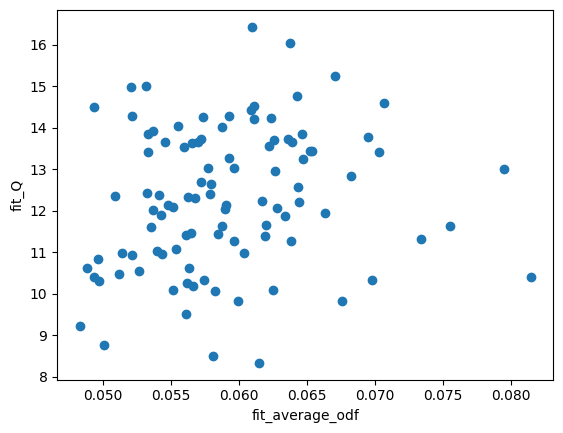

N_GEN = 1
fit1 : [0.0874139959172886, 0.07673789453446929, 0.07346081120509641, 0.08770521303319995, 0.07228474459627984, 0.06768116112993428, 0.07378296290901122, 0.07072603753330706, 0.07079268688709564, 0.08443125894553204, 0.07050192962403147, 0.08331725105624489, 0.07399957120909245, 0.07946545571542561, 0.06407362381940454, 0.0732266675564677, 0.06468195704341013, 0.06746210987041971, 0.0707072537841348, 0.06879244111208067, 0.06097002848310118, 0.0670483928943411, 0.08145576064471675, 0.07647956439058916, 0.06981402260002269, 0.0638119592764856, 0.0703265766895225, 0.06011481469150184, 0.07192888095978858, 0.06271371546620719, 0.06187376137450562, 0.06745777936339492, 0.06425849475558143, 0.07551370724140793, 0.0695157662432039, 0.06687569223087336, 0.06241119078542154, 0.07459034717398551, 0.06175305023095332, 0.06801656876723725, 0.06851997258469632, 0.06511914724883816, 0.06880614888491784, 0.061144856501627244, 0.05821046906432475, 0.06955108985870366, 0.06538477658925837, 0

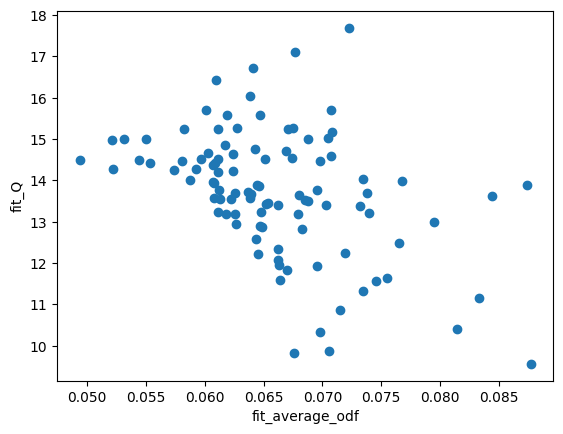

N_GEN = 2
fit1 : [0.08650426216959864, 0.09192247863295318, 0.0874139959172886, 0.08399016405142364, 0.0756145172246805, 0.08770521303319995, 0.07228474459627984, 0.08466651735704135, 0.06768116112993428, 0.07755372288147534, 0.07205095031434638, 0.07517429890133144, 0.0749123893925255, 0.06407362381940454, 0.06643204958147755, 0.06185967378559453, 0.07937516616276483, 0.08443125894553204, 0.06715386300287653, 0.07686456484869132, 0.07925712225195172, 0.06501606962085214, 0.07762364851623133, 0.06097002848310118, 0.07667784654690349, 0.08384206937665913, 0.07673789453446929, 0.07072603753330706, 0.08345704287421288, 0.07426575131764426, 0.0638119592764856, 0.07201236857474826, 0.07429330289196161, 0.08331725105624489, 0.07946545571542561, 0.06468195704341013, 0.07079268688709564, 0.06757925564447793, 0.06375760113759549, 0.07967787220119751, 0.07423778505954293, 0.06011481469150184, 0.06187376137450562, 0.07050192962403147, 0.07399957120909245, 0.07378296290901122, 0.06699238491443835,

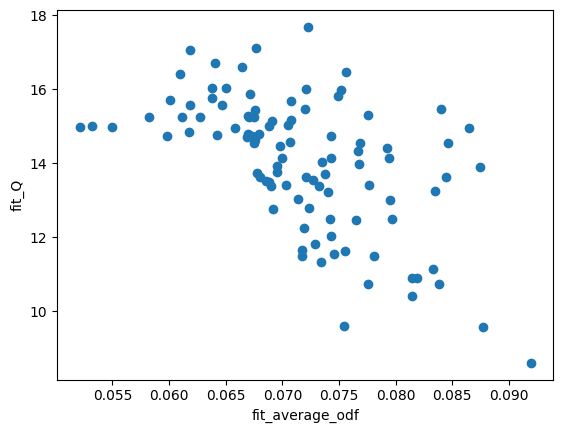

N_GEN = 3
fit1 : [0.08650426216959864, 0.09998941448406345, 0.06610668980131937, 0.08522756555806475, 0.08822995808044276, 0.08466651735704135, 0.06649353639964171, 0.09192247863295318, 0.0874139959172886, 0.08399016405142364, 0.08952621944192529, 0.0756145172246805, 0.07557251908339833, 0.08118431281203774, 0.0840057864118549, 0.07228474459627984, 0.07755372288147534, 0.08712235222568575, 0.06870880872275027, 0.08370894069536157, 0.07205095031434638, 0.08826087179152495, 0.08443125894553204, 0.07517429890133144, 0.07094830224666297, 0.067193448804374, 0.08667767651879682, 0.08116728418660257, 0.0749123893925255, 0.07025622790882151, 0.06768116112993428, 0.07040940674330247, 0.08345704287421288, 0.08329044467461061, 0.08770521303319995, 0.07729390677676506, 0.08395278844884127, 0.06859342506391079, 0.08566464296461763, 0.08331725105624489, 0.06407362381940454, 0.07747012087626194, 0.08293155696751632, 0.08384206937665913, 0.07072603753330706, 0.07445469827395956, 0.07201236857474826, 0

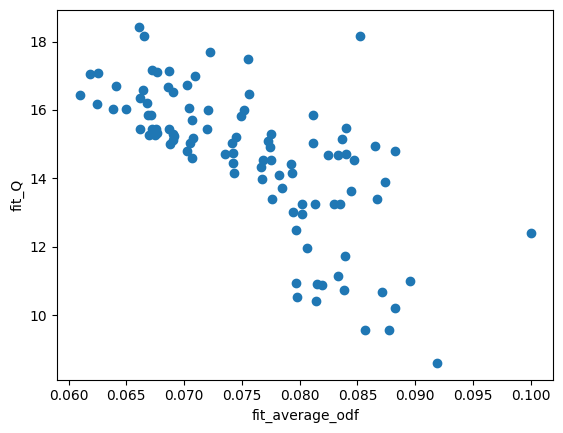

N_GEN = 4
fit1 : [0.09636734474391423, 0.08682326907385952, 0.08948677246248585, 0.07467414761930755, 0.08522756555806475, 0.1018290145659504, 0.09852330540205267, 0.09160805040327545, 0.09998941448406345, 0.07165141599253799, 0.09370187917660708, 0.08464095415688748, 0.07661363319091534, 0.08822995808044276, 0.0867558121105718, 0.08650426216959864, 0.08849692521983267, 0.09192247863295318, 0.08469916296161445, 0.07752283008137795, 0.06610668980131937, 0.0874139959172886, 0.08399016405142364, 0.08952621944192529, 0.0756145172246805, 0.08658136345729542, 0.0823464312801059, 0.0765910534165155, 0.07557251908339833, 0.06859375955370912, 0.08022483256374598, 0.08935234058247385, 0.07228474459627984, 0.0750345712161434, 0.08466651735704135, 0.06649353639964171, 0.07649281829044484, 0.08599367989837663, 0.08370894069536157, 0.08826087179152495, 0.07517429890133144, 0.08118431281203774, 0.08782885198311734, 0.07436807080089708, 0.08667767651879682, 0.07016589436299743, 0.0840057864118549, 0.0

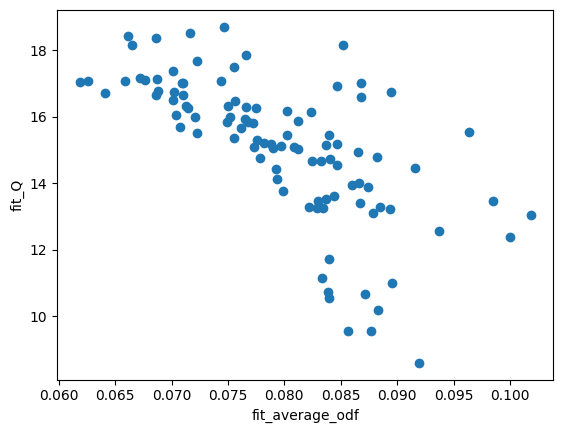

N_GEN = 5
fit1 : [0.09636734474391423, 0.08645609117569857, 0.06346866782007371, 0.07434333381707683, 0.08682326907385952, 0.0950790457119217, 0.10403426834470689, 0.07467414761930755, 0.08522756555806475, 0.10422444567271766, 0.0952410167797824, 0.07609668561512746, 0.0998936117647131, 0.08221742465873352, 0.08948677246248585, 0.07165141599253799, 0.09125198451965429, 0.10080346877916149, 0.10261520722954258, 0.08464095415688748, 0.07661363319091534, 0.09873006904946716, 0.08848408535299437, 0.08098963963635154, 0.07639107547985996, 0.06610668980131937, 0.07708636417288961, 0.100229803326401, 0.1018290145659504, 0.10108169985230375, 0.07557251908339833, 0.06859375955370912, 0.08825265874368075, 0.08897944462389216, 0.07228474459627984, 0.09431591838113604, 0.09160805040327545, 0.06649353639964171, 0.09998941448406345, 0.08822995808044276, 0.0867558121105718, 0.09852330540205267, 0.07436807080089708, 0.07016589436299743, 0.08650426216959864, 0.06128689609629343, 0.07103145716777949, 0.

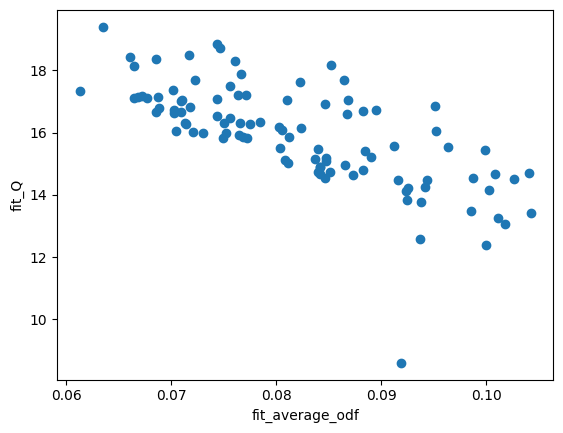

N_GEN = 6
fit1 : [0.077881003894092, 0.06346866782007371, 0.07434333381707683, 0.09461332095397579, 0.10403426834470689, 0.0950790457119217, 0.08522756555806475, 0.09752630782613318, 0.10422444567271766, 0.08762707562355009, 0.0998936117647131, 0.069822747290232, 0.07534060452455492, 0.07680039450951685, 0.09830735446726598, 0.08645609117569857, 0.08288692901168174, 0.08682326907385952, 0.08948677246248585, 0.07467414761930755, 0.09726157296330025, 0.10080346877916149, 0.10261520722954258, 0.0775514210151425, 0.09873006904946716, 0.09720894212779468, 0.0824718957372306, 0.08221742465873352, 0.09299060958875964, 0.0772819380800917, 0.07165141599253799, 0.100229803326401, 0.06729091629341599, 0.1018290145659504, 0.0952410167797824, 0.07609668561512746, 0.10108169985230375, 0.08464095415688748, 0.09720005583099843, 0.08825265874368075, 0.09562625340773286, 0.0736657934105564, 0.09636734474391423, 0.08098963963635154, 0.09998941448406345, 0.06610668980131937, 0.07708636417288961, 0.0940755

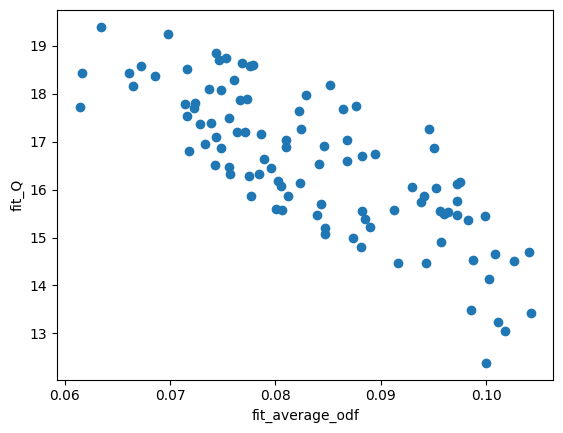

N_GEN = 7
fit1 : [0.077881003894092, 0.07048012948874248, 0.06346866782007371, 0.0751763314295083, 0.09461332095397579, 0.10403426834470689, 0.0950790457119217, 0.08522756555806475, 0.09752630782613318, 0.10422444567271766, 0.06514918858610158, 0.08762707562355009, 0.0998936117647131, 0.069822747290232, 0.07534060452455492, 0.05945700567063006, 0.07680039450951685, 0.09830735446726598, 0.08645609117569857, 0.07434333381707683, 0.08288692901168174, 0.08682326907385952, 0.07467414761930755, 0.09726157296330025, 0.09448652971322427, 0.0650203191042551, 0.06670095939011496, 0.10080346877916149, 0.10261520722954258, 0.0775514210151425, 0.09873006904946716, 0.09720894212779468, 0.0824718957372306, 0.06773478396047591, 0.08221742465873352, 0.09018814725043278, 0.09299060958875964, 0.0772819380800917, 0.08948677246248585, 0.07165141599253799, 0.100229803326401, 0.0787472810154637, 0.08629433017884827, 0.1018290145659504, 0.0952410167797824, 0.07609668561512746, 0.10108169985230375, 0.091640606

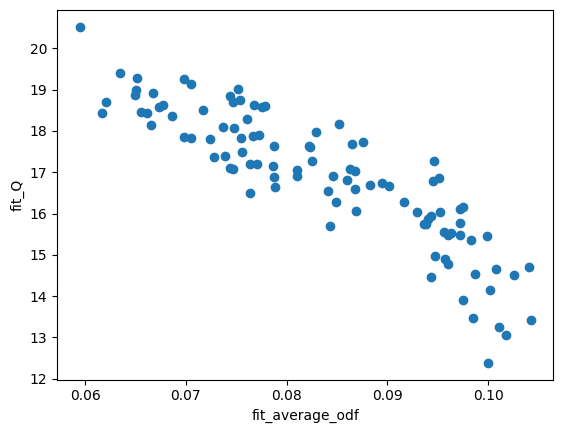

N_GEN = 8
fit1 : [0.077881003894092, 0.07048012948874248, 0.0751763314295083, 0.09461332095397579, 0.10403426834470689, 0.0950790457119217, 0.08522756555806475, 0.09752630782613318, 0.10422444567271766, 0.09809672188049885, 0.06981936704947102, 0.08762707562355009, 0.0998936117647131, 0.069822747290232, 0.07534060452455492, 0.05945700567063006, 0.07680039450951685, 0.09830735446726598, 0.08645609117569857, 0.06346866782007371, 0.07434333381707683, 0.08288692901168174, 0.08682326907385952, 0.06817499465344765, 0.07467414761930755, 0.08002983907466799, 0.09726157296330025, 0.102548840243459, 0.09448652971322427, 0.06514918858610158, 0.05960408339871828, 0.10080346877916149, 0.10261520722954258, 0.0775514210151425, 0.09873006904946716, 0.09720894212779468, 0.0824718957372306, 0.08221742465873352, 0.09018814725043278, 0.0772819380800917, 0.09929929651779354, 0.07236352853476886, 0.0833806797961841, 0.08948677246248585, 0.100229803326401, 0.08629433017884827, 0.09436420558326085, 0.06502031

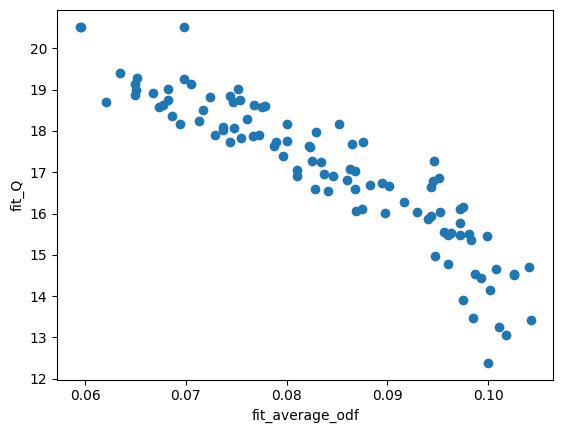

N_GEN = 9
fit1 : [0.077881003894092, 0.07048012948874248, 0.0751763314295083, 0.10403426834470689, 0.09805355282527844, 0.08522756555806475, 0.10422444567271766, 0.09457444844276458, 0.09809672188049885, 0.06981936704947102, 0.0998936117647131, 0.069822747290232, 0.07534060452455492, 0.05945700567063006, 0.07680039450951685, 0.09830735446726598, 0.06346866782007371, 0.07434333381707683, 0.09558089543739032, 0.08288692901168174, 0.09461332095397579, 0.07773354388085058, 0.0950790457119217, 0.06817499465344765, 0.07467414761930755, 0.08002983907466799, 0.07769133166603263, 0.09752630782613318, 0.102548840243459, 0.06514918858610158, 0.05960408339871828, 0.08762707562355009, 0.10080346877916149, 0.10261520722954258, 0.0775514210151425, 0.07002314948769273, 0.09873006904946716, 0.08645609117569857, 0.0772819380800917, 0.09929929651779354, 0.07236352853476886, 0.100229803326401, 0.09726157296330025, 0.09448652971322427, 0.0650203191042551, 0.1018290145659504, 0.07609668561512746, 0.10108169

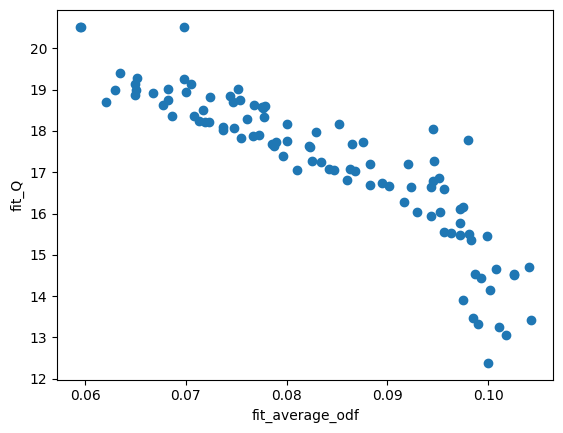

N_GEN = 10
fit1 : [0.07049990424348701, 0.07048012948874248, 0.10043742543783689, 0.0751763314295083, 0.08668405031126582, 0.10403426834470689, 0.09805355282527844, 0.10422444567271766, 0.09457444844276458, 0.06981936704947102, 0.069822747290232, 0.08159639541131711, 0.05945700567063006, 0.07620589548847688, 0.077881003894092, 0.08228685105786185, 0.06346866782007371, 0.07434333381707683, 0.09558089543739032, 0.09461332095397579, 0.0950790457119217, 0.06817499465344765, 0.08522756555806475, 0.102548840243459, 0.09752630782613318, 0.05960408339871828, 0.09809672188049885, 0.06364268631293421, 0.06786011699749699, 0.0998936117647131, 0.10080346877916149, 0.10261520722954258, 0.07534060452455492, 0.07680039450951685, 0.09206106185641466, 0.07002314948769273, 0.09873006904946716, 0.09830735446726598, 0.08288692901168174, 0.09929929651779354, 0.07236352853476886, 0.07773354388085058, 0.07467414761930755, 0.08002983907466799, 0.100229803326401, 0.07769133166603263, 0.09726157296330025, 0.094

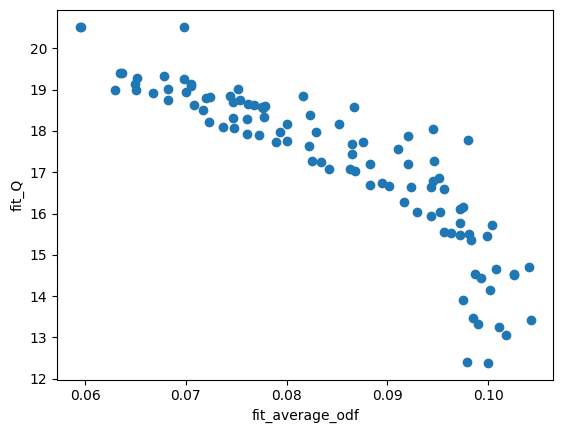

N_GEN = 11
fit1 : [0.10043742543783689, 0.08668405031126582, 0.10403426834470689, 0.09805355282527844, 0.09823521669129913, 0.10422444567271766, 0.09457444844276458, 0.06981936704947102, 0.05945700567063006, 0.08181873669220398, 0.07857409771155734, 0.07049990424348701, 0.08228685105786185, 0.07048012948874248, 0.10016373673716493, 0.06346866782007371, 0.09558089543739032, 0.09301751796978407, 0.0751763314295083, 0.08522756555806475, 0.09550840197218637, 0.102548840243459, 0.09752630782613318, 0.05960408339871828, 0.09809672188049885, 0.06364268631293421, 0.06786011699749699, 0.0998936117647131, 0.069822747290232, 0.10080346877916149, 0.10261520722954258, 0.08159639541131711, 0.09206106185641466, 0.07620589548847688, 0.077881003894092, 0.09873006904946716, 0.09830735446726598, 0.09541578721309345, 0.07434333381707683, 0.08288692901168174, 0.09929929651779354, 0.08021684994536442, 0.09461332095397579, 0.0950790457119217, 0.06817499465344765, 0.100229803326401, 0.09726157296330025, 0.091

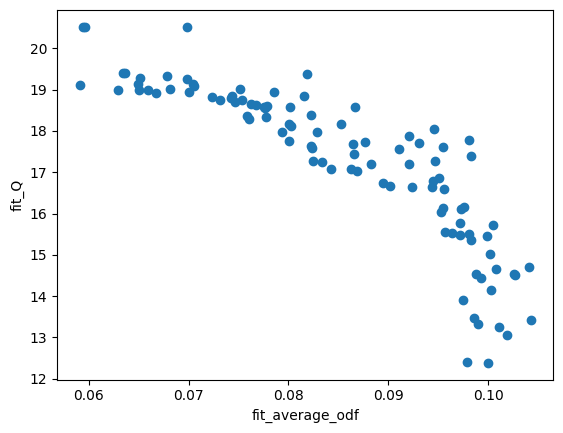

N_GEN = 12
fit1 : [0.11630264502988934, 0.08668405031126582, 0.09805355282527844, 0.10991369312834526, 0.09823521669129913, 0.09457444844276458, 0.06981936704947102, 0.10957742621484505, 0.07656699612102016, 0.05945700567063006, 0.08181873669220398, 0.07049990424348701, 0.08228685105786185, 0.07048012948874248, 0.06346866782007371, 0.09558089543739032, 0.10043742543783689, 0.09301751796978407, 0.10124758475345173, 0.0751763314295083, 0.08099328326115542, 0.10403426834470689, 0.08522756555806475, 0.09550840197218637, 0.09752630782613318, 0.10422444567271766, 0.05960408339871828, 0.06364268631293421, 0.06786011699749699, 0.069822747290232, 0.08159639541131711, 0.09206106185641466, 0.07857409771155734, 0.10016373673716493, 0.09541578721309345, 0.08288692901168174, 0.08021684994536442, 0.06717829104684549, 0.09461332095397579, 0.0950790457119217, 0.06817499465344765, 0.102548840243459, 0.09726157296330025, 0.09107019328264876, 0.06514918858610158, 0.09809672188049885, 0.08762707562355009, 

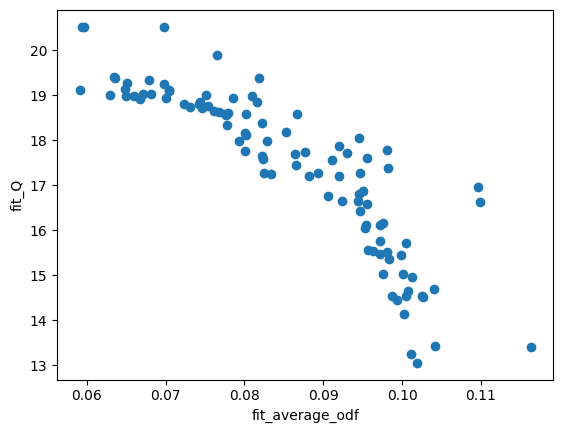

N_GEN = 13
fit1 : [0.11630264502988934, 0.09031777245595311, 0.08668405031126582, 0.09805355282527844, 0.10991369312834526, 0.09457444844276458, 0.10028887615338798, 0.06981936704947102, 0.10957742621484505, 0.07656699612102016, 0.05945700567063006, 0.08181873669220398, 0.08228685105786185, 0.06346866782007371, 0.10043742543783689, 0.09301751796978407, 0.10124758475345173, 0.0751763314295083, 0.08099328326115542, 0.10403426834470689, 0.08522756555806475, 0.09823521669129913, 0.09550840197218637, 0.10422444567271766, 0.05960408339871828, 0.06364268631293421, 0.08159639541131711, 0.06571453212299638, 0.0705596080579347, 0.09206106185641466, 0.07857409771155734, 0.07049990424348701, 0.07048012948874248, 0.10016373673716493, 0.09558089543739032, 0.08288692901168174, 0.08021684994536442, 0.09461332095397579, 0.0950790457119217, 0.0991482653152689, 0.102548840243459, 0.09752630782613318, 0.09557046438678297, 0.09107019328264876, 0.06786011699749699, 0.08762707562355009, 0.0998936117647131, 0

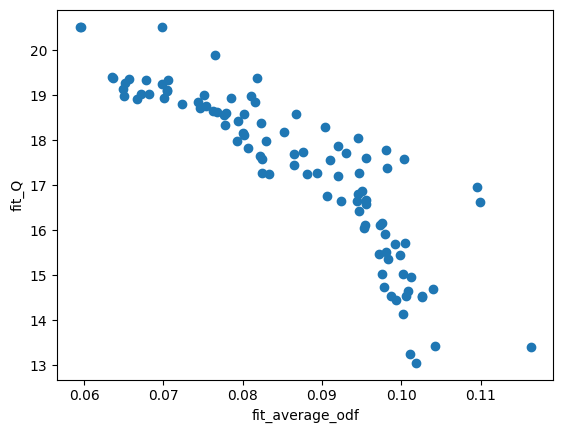

N_GEN = 14
fit1 : [0.11630264502988934, 0.09031777245595311, 0.08668405031126582, 0.09805355282527844, 0.10991369312834526, 0.0801016690169381, 0.09457444844276458, 0.10028887615338798, 0.06981936704947102, 0.08909282300936364, 0.10957742621484505, 0.05945700567063006, 0.08181873669220398, 0.09921686433294329, 0.08228685105786185, 0.10043742543783689, 0.09301751796978407, 0.10124758475345173, 0.08099328326115542, 0.10403426834470689, 0.08522756555806475, 0.09823521669129913, 0.09550840197218637, 0.10842037536330586, 0.05960408339871828, 0.07684187689398209, 0.07656699612102016, 0.08159639541131711, 0.09206106185641466, 0.07155352493273119, 0.0753911598963807, 0.0816867681348495, 0.07857409771155734, 0.10016373673716493, 0.09558089543739032, 0.08288692901168174, 0.08021684994536442, 0.09461332095397579, 0.0950790457119217, 0.0991482653152689, 0.102548840243459, 0.09752630782613318, 0.09557046438678297, 0.10422444567271766, 0.09107019328264876, 0.06619558309395276, 0.08762707562355009, 0

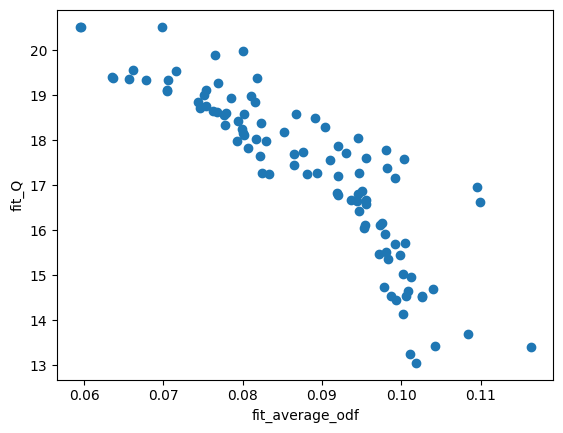

N_GEN = 15
fit1 : [0.11630264502988934, 0.09618930487556372, 0.09805355282527844, 0.10991369312834526, 0.0801016690169381, 0.10028887615338798, 0.10957742621484505, 0.08731169282082747, 0.07662472648061532, 0.08181873669220398, 0.09921686433294329, 0.0839214190341994, 0.08331630138069736, 0.10043742543783689, 0.09031777245595311, 0.10769108567994991, 0.08668405031126582, 0.08099328326115542, 0.07747112125553872, 0.09823521669129913, 0.09550840197218637, 0.10842037536330586, 0.09457444844276458, 0.06981936704947102, 0.08909282300936364, 0.07656699612102016, 0.08159639541131711, 0.05945700567063006, 0.07857409771155734, 0.08228685105786185, 0.10016373673716493, 0.09558089543739032, 0.09301751796978407, 0.10124758475345173, 0.08640661558668458, 0.09461332095397579, 0.10403426834470689, 0.0950790457119217, 0.08522756555806475, 0.0991482653152689, 0.09752630782613318, 0.09557046438678297, 0.10422444567271766, 0.05960408339871828, 0.07240291607936057, 0.07684187689398209, 0.07280333478699005

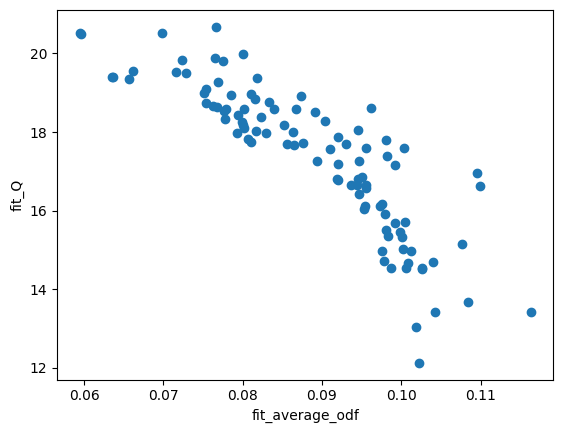

N_GEN = 16
fit1 : [0.09618930487556372, 0.10991369312834526, 0.0801016690169381, 0.12198862996491253, 0.10153902659682057, 0.08756599298830911, 0.10957742621484505, 0.08731169282082747, 0.07662472648061532, 0.08181873669220398, 0.11630264502988934, 0.08331630138069736, 0.0839214190341994, 0.10043742543783689, 0.09031777245595311, 0.10769108567994991, 0.08668405031126582, 0.08099328326115542, 0.09805355282527844, 0.07747112125553872, 0.10842037536330586, 0.09457444844276458, 0.10028887615338798, 0.06981936704947102, 0.08909282300936364, 0.07656699612102016, 0.08159639541131711, 0.05945700567063006, 0.07857409771155734, 0.09921686433294329, 0.08228685105786185, 0.10016373673716493, 0.10689582197086049, 0.09301751796978407, 0.09816241035528511, 0.10124758475345173, 0.08640661558668458, 0.10403426834470689, 0.06668748822728335, 0.08522756555806475, 0.09823521669129913, 0.09550840197218637, 0.05960408339871828, 0.07240291607936057, 0.07684187689398209, 0.07280333478699005, 0.099893611764713

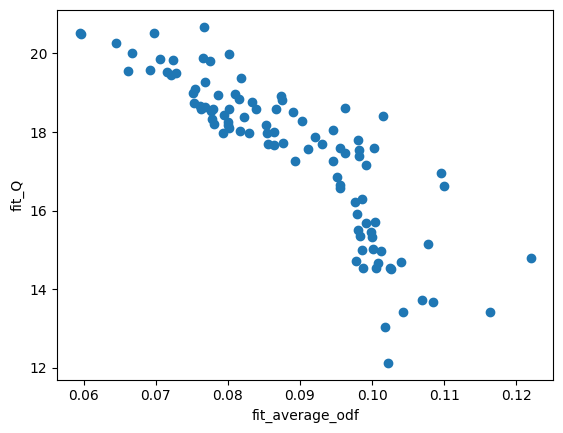

N_GEN = 17
fit1 : [0.10991369312834526, 0.1079872132751364, 0.0801016690169381, 0.12198862996491253, 0.10153902659682057, 0.10957742621484505, 0.09631305245379801, 0.07662472648061532, 0.08181873669220398, 0.11630264502988934, 0.0792493502654216, 0.10769108567994991, 0.08099328326115542, 0.09618930487556372, 0.09805355282527844, 0.07747112125553872, 0.10046660484328249, 0.10842037536330586, 0.10028887615338798, 0.06981936704947102, 0.08756599298830911, 0.07656699612102016, 0.08731169282082747, 0.07009576213919952, 0.05945700567063006, 0.10480195243847984, 0.086814545909538, 0.10078168144629772, 0.09921686433294329, 0.0839214190341994, 0.08331630138069736, 0.10689582197086049, 0.10043742543783689, 0.09031777245595311, 0.09816241035528511, 0.08668405031126582, 0.10403426834470689, 0.06668748822728335, 0.09823521669129913, 0.09550840197218637, 0.05960408339871828, 0.07240291607936057, 0.09457444844276458, 0.07684187689398209, 0.08909282300936364, 0.07280333478699005, 0.07063736264345255, 

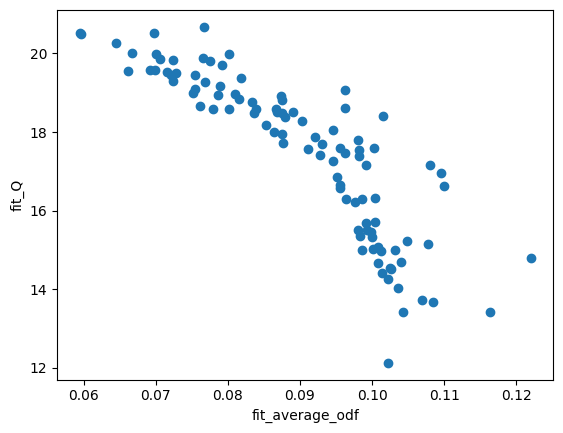

N_GEN = 18
fit1 : [0.10991369312834526, 0.1079872132751364, 0.09275169259352997, 0.0801016690169381, 0.12198862996491253, 0.10153902659682057, 0.10957742621484505, 0.09631305245379801, 0.07662472648061532, 0.11630264502988934, 0.0792493502654216, 0.09543168044167101, 0.10769108567994991, 0.09618930487556372, 0.09805355282527844, 0.07747112125553872, 0.10046660484328249, 0.07320253011421907, 0.10028887615338798, 0.06981936704947102, 0.11175521419905718, 0.07656699612102016, 0.09220394909248941, 0.08731169282082747, 0.05945700567063006, 0.10480195243847984, 0.10992116685107228, 0.08181873669220398, 0.10563751964160724, 0.09921686433294329, 0.10689582197086049, 0.10043742543783689, 0.09031777245595311, 0.09816241035528511, 0.08099328326115542, 0.06668748822728335, 0.09823521669129913, 0.09550840197218637, 0.10842037536330586, 0.07779470145525712, 0.05960408339871828, 0.07240291607936057, 0.09457444844276458, 0.08909282300936364, 0.08756599298830911, 0.07063736264345255, 0.0815963954113171

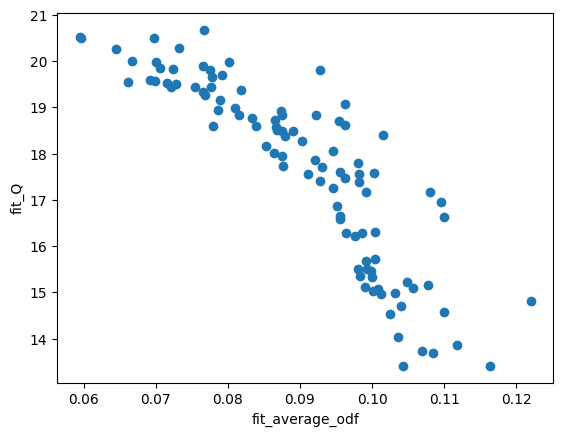

N_GEN = 19
fit1 : [0.0915226315667922, 0.10971596941418833, 0.10991369312834526, 0.1079872132751364, 0.09275169259352997, 0.12198862996491253, 0.10153902659682057, 0.10957742621484505, 0.09631305245379801, 0.07662472648061532, 0.11630264502988934, 0.10584773675417766, 0.09127238044562892, 0.09543168044167101, 0.10769108567994991, 0.09618930487556372, 0.09805355282527844, 0.0801016690169381, 0.07320253011421907, 0.10028887615338798, 0.06981936704947102, 0.11175521419905718, 0.09220394909248941, 0.05945700567063006, 0.10992116685107228, 0.09710867592893736, 0.10563751964160724, 0.09921686433294329, 0.0792493502654216, 0.10689582197086049, 0.1010283948205031, 0.09031777245595311, 0.1000420311998089, 0.09816241035528511, 0.06668748822728335, 0.07747112125553872, 0.10046660484328249, 0.09823521669129913, 0.10842037536330586, 0.05960408339871828, 0.09457444844276458, 0.08909282300936364, 0.08756599298830911, 0.08090963630477707, 0.07656699612102016, 0.08731169282082747, 0.07009576213919952, 

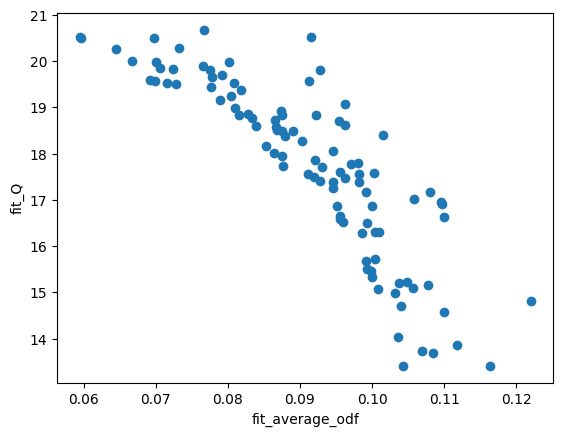

N_GEN = 20
fit1 : [0.0915226315667922, 0.10971596941418833, 0.10991369312834526, 0.1079872132751364, 0.09275169259352997, 0.11622530342102871, 0.12198862996491253, 0.10153902659682057, 0.10957742621484505, 0.09631305245379801, 0.07662472648061532, 0.11630264502988934, 0.10584773675417766, 0.09127238044562892, 0.09543168044167101, 0.10769108567994991, 0.09618930487556372, 0.09805355282527844, 0.08624486712603052, 0.0801016690169381, 0.07320253011421907, 0.10028887615338798, 0.06981936704947102, 0.11175521419905718, 0.09220394909248941, 0.05945700567063006, 0.10992116685107228, 0.09710867592893736, 0.10563751964160724, 0.09921686433294329, 0.0792493502654216, 0.10689582197086049, 0.1010283948205031, 0.09031777245595311, 0.1000420311998089, 0.09816241035528511, 0.06668748822728335, 0.07747112125553872, 0.10046660484328249, 0.09823521669129913, 0.10842037536330586, 0.05960408339871828, 0.09457444844276458, 0.08909282300936364, 0.08090963630477707, 0.07656699612102016, 0.07009576213919952, 

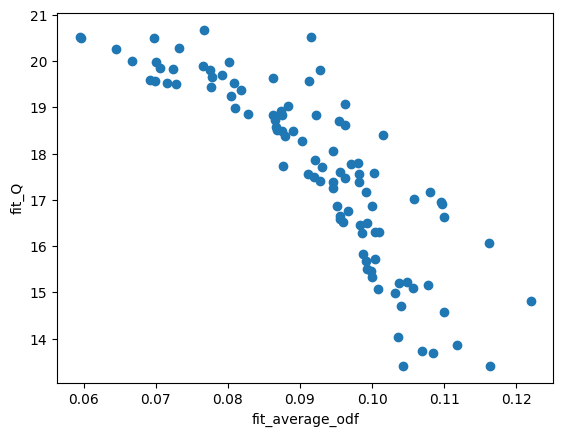

N_GEN = 21
fit1 : [0.0915226315667922, 0.10971596941418833, 0.10991369312834526, 0.1079872132751364, 0.09275169259352997, 0.11622530342102871, 0.12198862996491253, 0.10153902659682057, 0.10957742621484505, 0.09631305245379801, 0.07662472648061532, 0.11630264502988934, 0.10584773675417766, 0.09127238044562892, 0.09543168044167101, 0.09618930487556372, 0.09805355282527844, 0.08624486712603052, 0.0801016690169381, 0.07320253011421907, 0.10028887615338798, 0.06981936704947102, 0.11175521419905718, 0.09220394909248941, 0.10843847255889728, 0.05945700567063006, 0.10992116685107228, 0.09710867592893736, 0.09921686433294329, 0.0792493502654216, 0.07626025112114947, 0.1010283948205031, 0.09031777245595311, 0.1000420311998089, 0.10769108567994991, 0.09816241035528511, 0.06668748822728335, 0.07747112125553872, 0.10046660484328249, 0.09823521669129913, 0.10842037536330586, 0.05960408339871828, 0.09457444844276458, 0.08960985655097647, 0.10566865357465045, 0.08090963630477707, 0.07656699612102016, 

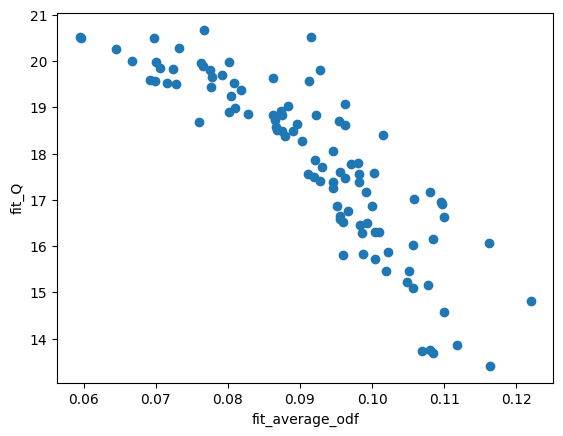

N_GEN = 22
fit1 : [0.0915226315667922, 0.10971596941418833, 0.10991369312834526, 0.1079872132751364, 0.09275169259352997, 0.11622530342102871, 0.12198862996491253, 0.10153902659682057, 0.10957742621484505, 0.09631305245379801, 0.07662472648061532, 0.11630264502988934, 0.10584773675417766, 0.09127238044562892, 0.09543168044167101, 0.09618930487556372, 0.09805355282527844, 0.11279462481573135, 0.07320253011421907, 0.10028887615338798, 0.06981936704947102, 0.09220394909248941, 0.10843847255889728, 0.09972509367521583, 0.05945700567063006, 0.08675575559485918, 0.09710867592893736, 0.09921686433294329, 0.1010283948205031, 0.1000420311998089, 0.10769108567994991, 0.09816241035528511, 0.06668748822728335, 0.08970963947290943, 0.10046660484328249, 0.09823521669129913, 0.08624486712603052, 0.0801016690169381, 0.05960408339871828, 0.09457444844276458, 0.09034624610851814, 0.08843310404886551, 0.11175521419905718, 0.10566865357465045, 0.07009576213919952, 0.10992116685107228, 0.0644566095051905, 

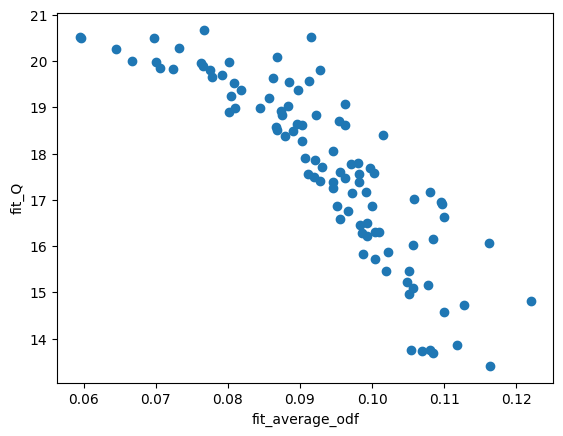

N_GEN = 23
fit1 : [0.0915226315667922, 0.09275169259352997, 0.11622530342102871, 0.12198862996491253, 0.10153902659682057, 0.09631305245379801, 0.11150960126574502, 0.07662472648061532, 0.11630264502988934, 0.09127238044562892, 0.10971596941418833, 0.09543168044167101, 0.09618930487556372, 0.09805355282527844, 0.10991369312834526, 0.11279462481573135, 0.1079872132751364, 0.07320253011421907, 0.10028887615338798, 0.06981936704947102, 0.10957742621484505, 0.09220394909248941, 0.09972509367521583, 0.05945700567063006, 0.08675575559485918, 0.09500306057377987, 0.09710867592893736, 0.10584773675417766, 0.09921686433294329, 0.09816241035528511, 0.06668748822728335, 0.09823521669129913, 0.08624486712603052, 0.0801016690169381, 0.109848264626992, 0.05960408339871828, 0.08843310404886551, 0.10843847255889728, 0.07009576213919952, 0.11189647991063914, 0.09489667747575557, 0.0644566095051905, 0.1084392567728831, 0.08970963947290943, 0.0792493502654216, 0.07626025112114947, 0.08576722367925646, 0.

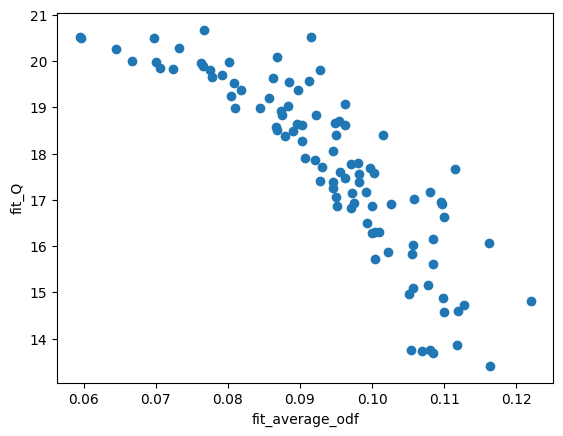

N_GEN = 24
fit1 : [0.10384866656347193, 0.0915226315667922, 0.09275169259352997, 0.11622530342102871, 0.12198862996491253, 0.10153902659682057, 0.09631305245379801, 0.11150960126574502, 0.07662472648061532, 0.11630264502988934, 0.09127238044562892, 0.10971596941418833, 0.09543168044167101, 0.09618930487556372, 0.09805355282527844, 0.10991369312834526, 0.11279462481573135, 0.1079872132751364, 0.11031870079013692, 0.07320253011421907, 0.10028887615338798, 0.06981936704947102, 0.10957742621484505, 0.09220394909248941, 0.09972509367521583, 0.05945700567063006, 0.08675575559485918, 0.09500306057377987, 0.10620766943368147, 0.09710867592893736, 0.10584773675417766, 0.09921686433294329, 0.09816241035528511, 0.06668748822728335, 0.11292144029343634, 0.09823521669129913, 0.11027369094798464, 0.08624486712603052, 0.0801016690169381, 0.05960408339871828, 0.08843310404886551, 0.10843847255889728, 0.07009576213919952, 0.11189647991063914, 0.09489667747575557, 0.1084392567728831, 0.0644566095051905,

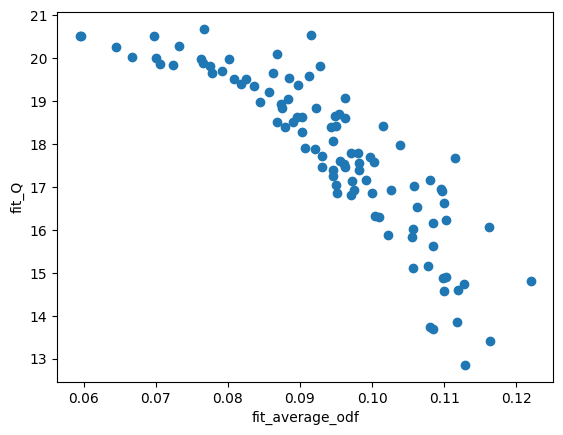

N_GEN = 25
fit1 : [0.10384866656347193, 0.0915226315667922, 0.09275169259352997, 0.11622530342102871, 0.12198862996491253, 0.10153902659682057, 0.09631305245379801, 0.11150960126574502, 0.07662472648061532, 0.11630264502988934, 0.09127238044562892, 0.10971596941418833, 0.09543168044167101, 0.11506492204307035, 0.07894135429070943, 0.10944644610402132, 0.09618930487556372, 0.09805355282527844, 0.10991369312834526, 0.11279462481573135, 0.11031870079013692, 0.10028887615338798, 0.06981936704947102, 0.10957742621484505, 0.09220394909248941, 0.09972509367521583, 0.05945700567063006, 0.08675575559485918, 0.09710867592893736, 0.09888187379813951, 0.09816241035528511, 0.11292144029343634, 0.1079872132751364, 0.0960253441093857, 0.09823521669129913, 0.11027369094798464, 0.08624486712603052, 0.0801016690169381, 0.05960408339871828, 0.07320253011421907, 0.08843310404886551, 0.10847378444736226, 0.10843847255889728, 0.11189647991063914, 0.09489667747575557, 0.08970963947290943, 0.09500306057377987

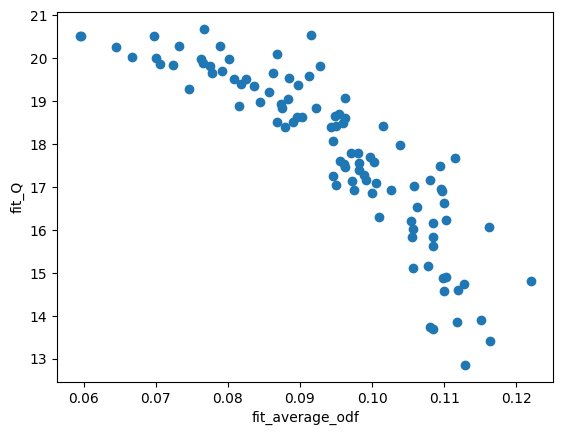

N_GEN = 26
fit1 : [0.10384866656347193, 0.0915226315667922, 0.07014330917498508, 0.09275169259352997, 0.11622530342102871, 0.12198862996491253, 0.10153902659682057, 0.09631305245379801, 0.11150960126574502, 0.07662472648061532, 0.11630264502988934, 0.09127238044562892, 0.10971596941418833, 0.09543168044167101, 0.11506492204307035, 0.07894135429070943, 0.10944644610402132, 0.09618930487556372, 0.09805355282527844, 0.10991369312834526, 0.11279462481573135, 0.11031870079013692, 0.10028887615338798, 0.06981936704947102, 0.10957742621484505, 0.09972509367521583, 0.05945700567063006, 0.08675575559485918, 0.09260281179020691, 0.09710867592893736, 0.09888187379813951, 0.09816241035528511, 0.11292144029343634, 0.1079872132751364, 0.0960253441093857, 0.09823521669129913, 0.11027369094798464, 0.08624486712603052, 0.0801016690169381, 0.05960408339871828, 0.07320253011421907, 0.08843310404886551, 0.10847378444736226, 0.09220394909248941, 0.10843847255889728, 0.11189647991063914, 0.09489667747575557

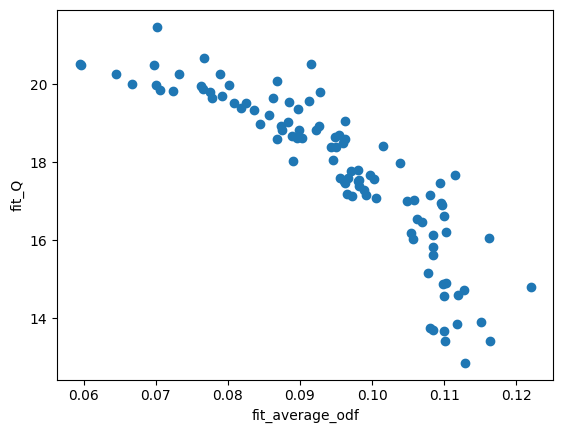

N_GEN = 27
fit1 : [0.10384866656347193, 0.0915226315667922, 0.07014330917498508, 0.09648550555262173, 0.09275169259352997, 0.11622530342102871, 0.12198862996491253, 0.10153902659682057, 0.09631305245379801, 0.11150960126574502, 0.07662472648061532, 0.11630264502988934, 0.09127238044562892, 0.10971596941418833, 0.09543168044167101, 0.11506492204307035, 0.07894135429070943, 0.10944644610402132, 0.09618930487556372, 0.09805355282527844, 0.10991369312834526, 0.11279462481573135, 0.11031870079013692, 0.10028887615338798, 0.06981936704947102, 0.10957742621484505, 0.09972509367521583, 0.05945700567063006, 0.08675575559485918, 0.09260281179020691, 0.09710867592893736, 0.09888187379813951, 0.09816241035528511, 0.11292144029343634, 0.1079872132751364, 0.0960253441093857, 0.09823521669129913, 0.11027369094798464, 0.08624486712603052, 0.0801016690169381, 0.05960408339871828, 0.07320253011421907, 0.08843310404886551, 0.11376156583714452, 0.10899704400563989, 0.09220394909248941, 0.11189647991063914

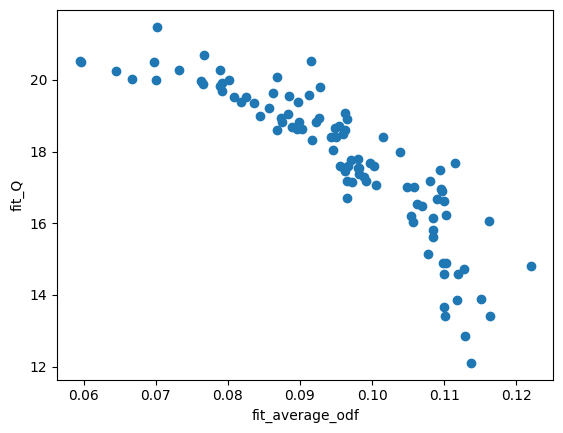

N_GEN = 28
fit1 : [0.10384866656347193, 0.0915226315667922, 0.07014330917498508, 0.09648550555262173, 0.11622530342102871, 0.09469990942379952, 0.12198862996491253, 0.10153902659682057, 0.09631305245379801, 0.11150960126574502, 0.07662472648061532, 0.11630264502988934, 0.10971596941418833, 0.09543168044167101, 0.11506492204307035, 0.07894135429070943, 0.10944644610402132, 0.09618930487556372, 0.09805355282527844, 0.11279462481573135, 0.11031870079013692, 0.1102624221679149, 0.09275169259352997, 0.09913607058407034, 0.10028887615338798, 0.06981936704947102, 0.10957742621484505, 0.09972509367521583, 0.05945700567063006, 0.08675575559485918, 0.09710867592893736, 0.09127238044562892, 0.09816241035528511, 0.11292144029343634, 0.10991369312834526, 0.1079872132751364, 0.0960253441093857, 0.11027369094798464, 0.08624486712603052, 0.0801016690169381, 0.05960408339871828, 0.07320253011421907, 0.11376156583714452, 0.10899704400563989, 0.10427302831569804, 0.11189647991063914, 0.09489667747575557,

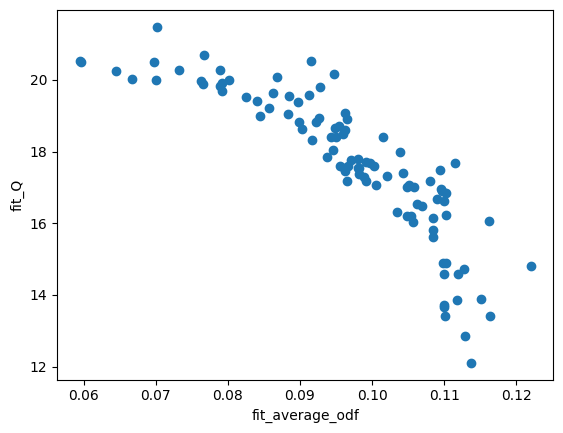

N_GEN = 29
fit1 : [0.10384866656347193, 0.1268683152354943, 0.0915226315667922, 0.07014330917498508, 0.09648550555262173, 0.11622530342102871, 0.09469990942379952, 0.12198862996491253, 0.10153902659682057, 0.09631305245379801, 0.11150960126574502, 0.07662472648061532, 0.11630264502988934, 0.10971596941418833, 0.09543168044167101, 0.11506492204307035, 0.07894135429070943, 0.10944644610402132, 0.09618930487556372, 0.09805355282527844, 0.11031870079013692, 0.1102624221679149, 0.09275169259352997, 0.09913607058407034, 0.10028887615338798, 0.06981936704947102, 0.10957742621484505, 0.09972509367521583, 0.05945700567063006, 0.08675575559485918, 0.11344885081725026, 0.1069835282896132, 0.09710867592893736, 0.09127238044562892, 0.11167936430207405, 0.09816241035528511, 0.11292144029343634, 0.10991369312834526, 0.11279462481573135, 0.1079872132751364, 0.09242769275786074, 0.0960253441093857, 0.08624486712603052, 0.0801016690169381, 0.05960408339871828, 0.07320253011421907, 0.11376156583714452, 0

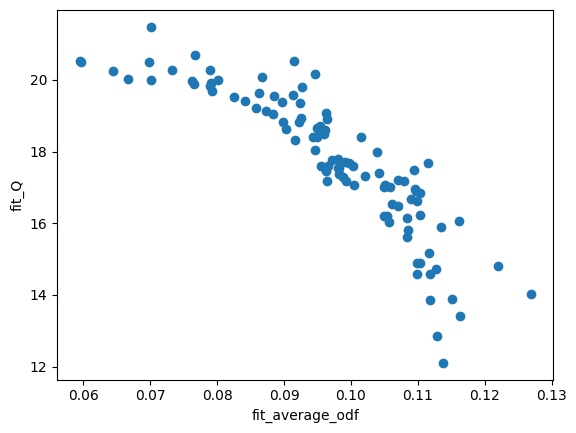

N_GEN = 30
fit1 : [0.10384866656347193, 0.1268683152354943, 0.0915226315667922, 0.10103090563180928, 0.07014330917498508, 0.09648550555262173, 0.11622530342102871, 0.09469990942379952, 0.12198862996491253, 0.10153902659682057, 0.09631305245379801, 0.11150960126574502, 0.07662472648061532, 0.11630264502988934, 0.06546091382356135, 0.10971596941418833, 0.09543168044167101, 0.11506492204307035, 0.07894135429070943, 0.10944644610402132, 0.09618930487556372, 0.09805355282527844, 0.11031870079013692, 0.1102624221679149, 0.09275169259352997, 0.09913607058407034, 0.10028887615338798, 0.06981936704947102, 0.10957742621484505, 0.09972509367521583, 0.08675575559485918, 0.11344885081725026, 0.1069835282896132, 0.09710867592893736, 0.11177566701669363, 0.09127238044562892, 0.09816241035528511, 0.11292144029343634, 0.10991369312834526, 0.11279462481573135, 0.07765598081956604, 0.1079872132751364, 0.09242769275786074, 0.0960253441093857, 0.08624486712603052, 0.0801016690169381, 0.05960408339871828, 0

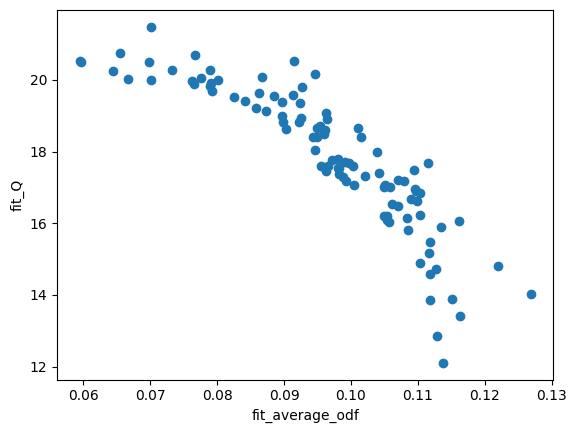

N_GEN = 31
fit1 : [0.1268683152354943, 0.0915226315667922, 0.10700910229378695, 0.07014330917498508, 0.11622530342102871, 0.09469990942379952, 0.12198862996491253, 0.09894970676460468, 0.11150960126574502, 0.07662472648061532, 0.11630264502988934, 0.106316777587968, 0.10971596941418833, 0.11506492204307035, 0.07894135429070943, 0.10103090563180928, 0.10944644610402132, 0.11031870079013692, 0.1102624221679149, 0.09648550555262173, 0.09275169259352997, 0.06981936704947102, 0.10153902659682057, 0.10957742621484505, 0.09631305245379801, 0.08675575559485918, 0.06752494873106994, 0.11344885081725026, 0.10384866656347193, 0.1069835282896132, 0.11177566701669363, 0.06546091382356135, 0.09127238044562892, 0.09543168044167101, 0.11292144029343634, 0.09618930487556372, 0.10991369312834526, 0.11279462481573135, 0.07765598081956604, 0.1079872132751364, 0.09242769275786074, 0.08624486712603052, 0.0801016690169381, 0.07320253011421907, 0.11376156583714452, 0.10899704400563989, 0.10427302831569804, 0.

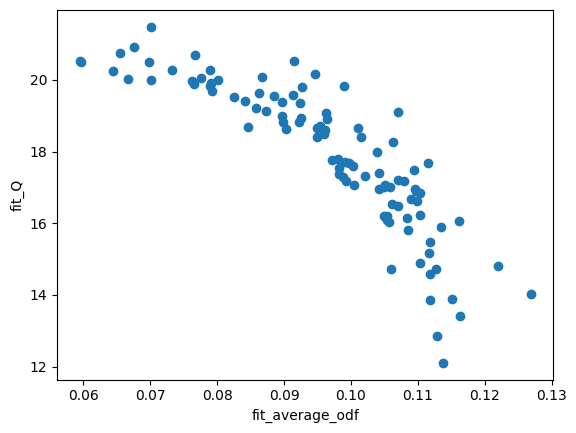

N_GEN = 32
fit1 : [0.1268683152354943, 0.0915226315667922, 0.10700910229378695, 0.07014330917498508, 0.09469990942379952, 0.12198862996491253, 0.09894970676460468, 0.1207119895338478, 0.11150960126574502, 0.07662472648061532, 0.106316777587968, 0.10971596941418833, 0.07894135429070943, 0.10103090563180928, 0.10944644610402132, 0.11031870079013692, 0.1102624221679149, 0.09648550555262173, 0.09275169259352997, 0.11622530342102871, 0.11658978026676381, 0.06981936704947102, 0.10153902659682057, 0.10957742621484505, 0.09631305245379801, 0.08990085608971533, 0.06752494873106994, 0.10384866656347193, 0.11630264502988934, 0.1069835282896132, 0.09627916147586647, 0.06546091382356135, 0.09127238044562892, 0.09543168044167101, 0.11506492204307035, 0.09618930487556372, 0.10991369312834526, 0.1079872132751364, 0.09242769275786074, 0.07320253011421907, 0.10899704400563989, 0.10427302831569804, 0.08675575559485918, 0.11344885081725026, 0.09260281179020691, 0.1133544866808058, 0.10620766943368147, 0.1

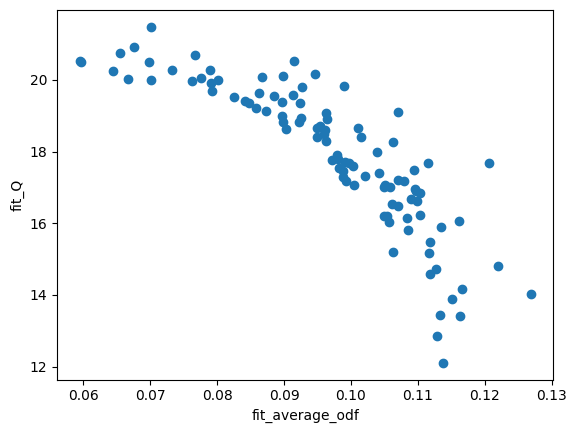

N_GEN = 33
fit1 : [0.1268683152354943, 0.0915226315667922, 0.10700910229378695, 0.07014330917498508, 0.09469990942379952, 0.12198862996491253, 0.08892873522633762, 0.09894970676460468, 0.1207119895338478, 0.11150960126574502, 0.106316777587968, 0.10971596941418833, 0.07894135429070943, 0.10103090563180928, 0.10944644610402132, 0.1105912257319178, 0.1102624221679149, 0.09648550555262173, 0.09275169259352997, 0.11622530342102871, 0.10153902659682057, 0.11085830588106611, 0.10957742621484505, 0.09631305245379801, 0.08990085608971533, 0.06752494873106994, 0.07662472648061532, 0.11790028042958889, 0.10384866656347193, 0.1069835282896132, 0.09627916147586647, 0.06546091382356135, 0.09127238044562892, 0.09543168044167101, 0.09618930487556372, 0.10991369312834526, 0.1079872132751364, 0.11031870079013692, 0.09242769275786074, 0.11658978026676381, 0.07320253011421907, 0.06981936704947102, 0.10899704400563989, 0.10427302831569804, 0.08675575559485918, 0.11344885081725026, 0.09260281179020691, 0.1

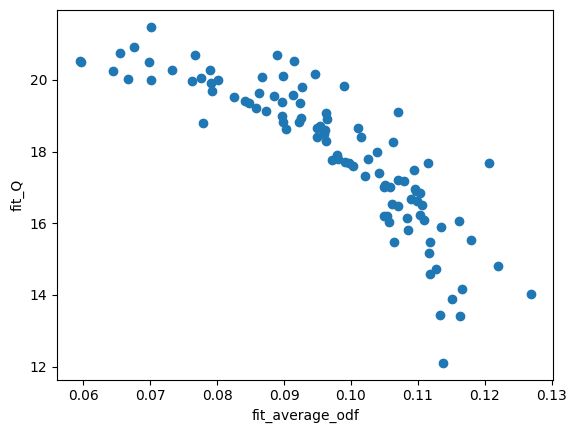

N_GEN = 34
fit1 : [0.1268683152354943, 0.0915226315667922, 0.10700910229378695, 0.07014330917498508, 0.09469990942379952, 0.12198862996491253, 0.08892873522633762, 0.09894970676460468, 0.1207119895338478, 0.11150960126574502, 0.106316777587968, 0.10971596941418833, 0.07894135429070943, 0.10103090563180928, 0.10944644610402132, 0.1105912257319178, 0.1102624221679149, 0.09648550555262173, 0.09275169259352997, 0.11622530342102871, 0.10153902659682057, 0.11085830588106611, 0.10957742621484505, 0.09631305245379801, 0.08990085608971533, 0.06752494873106994, 0.07662472648061532, 0.11790028042958889, 0.10384866656347193, 0.1069835282896132, 0.09627916147586647, 0.06546091382356135, 0.09127238044562892, 0.09543168044167101, 0.09618930487556372, 0.10991369312834526, 0.1079872132751364, 0.11031870079013692, 0.09242769275786074, 0.10859296442956619, 0.11658978026676381, 0.07320253011421907, 0.06981936704947102, 0.10899704400563989, 0.10427302831569804, 0.08675575559485918, 0.11344885081725026, 0.0

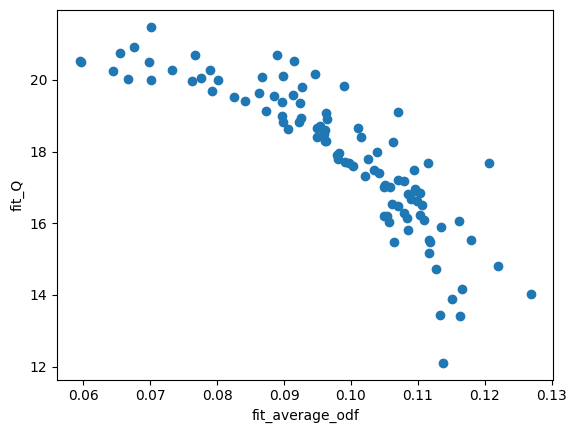

N_GEN = 35
fit1 : [0.1268683152354943, 0.0915226315667922, 0.12326647043558474, 0.10700910229378695, 0.07014330917498508, 0.09469990942379952, 0.12198862996491253, 0.08892873522633762, 0.09894970676460468, 0.1207119895338478, 0.11150960126574502, 0.106316777587968, 0.10971596941418833, 0.07894135429070943, 0.10103090563180928, 0.10944644610402132, 0.09332102360742325, 0.1105912257319178, 0.1102624221679149, 0.09648550555262173, 0.09275169259352997, 0.10153902659682057, 0.10957742621484505, 0.09631305245379801, 0.08990085608971533, 0.11756029637056642, 0.06752494873106994, 0.07662472648061532, 0.11790028042958889, 0.10384866656347193, 0.1069835282896132, 0.06546091382356135, 0.09127238044562892, 0.09543168044167101, 0.09618930487556372, 0.10991369312834526, 0.1079872132751364, 0.11031870079013692, 0.09242769275786074, 0.10859296442956619, 0.11622530342102871, 0.11658978026676381, 0.07320253011421907, 0.06981936704947102, 0.11085830588106611, 0.0996680624723771, 0.10899704400563989, 0.10

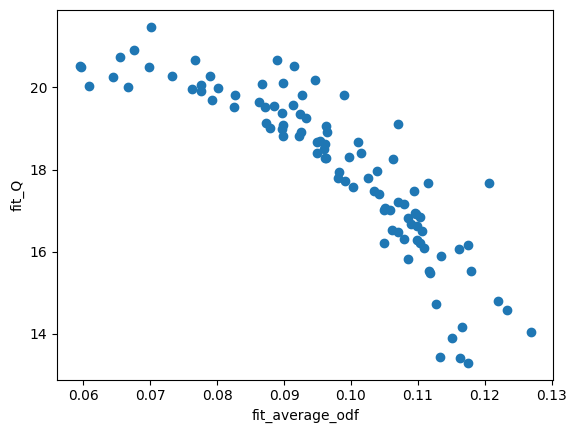

N_GEN = 36
fit1 : [0.1268683152354943, 0.0915226315667922, 0.12326647043558474, 0.10700910229378695, 0.07014330917498508, 0.09469990942379952, 0.12198862996491253, 0.08892873522633762, 0.09894970676460468, 0.1207119895338478, 0.11150960126574502, 0.106316777587968, 0.10971596941418833, 0.0965768154587853, 0.07894135429070943, 0.10103090563180928, 0.10944644610402132, 0.1105912257319178, 0.1102624221679149, 0.09275169259352997, 0.10153902659682057, 0.09786971615572004, 0.10957742621484505, 0.08990085608971533, 0.11756029637056642, 0.06752494873106994, 0.07662472648061532, 0.11790028042958889, 0.10384866656347193, 0.1069835282896132, 0.06546091382356135, 0.09127238044562892, 0.09332102360742325, 0.10991369312834526, 0.1079872132751364, 0.11031870079013692, 0.09242769275786074, 0.10859296442956619, 0.09648550555262173, 0.11622530342102871, 0.11658978026676381, 0.07320253011421907, 0.06981936704947102, 0.11085830588106611, 0.0996680624723771, 0.10899704400563989, 0.07672631820603902, 0.104

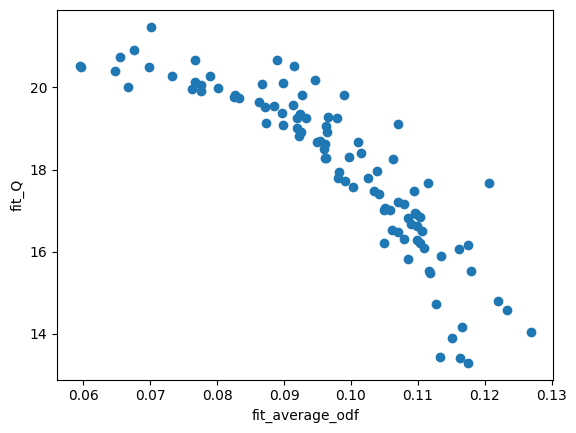

N_GEN = 37
fit1 : [0.1268683152354943, 0.12326647043558474, 0.10700910229378695, 0.07014330917498508, 0.09296593609447096, 0.09469990942379952, 0.12198862996491253, 0.09894970676460468, 0.1207119895338478, 0.11150960126574502, 0.1110100565750246, 0.0915226315667922, 0.106316777587968, 0.0965768154587853, 0.10103090563180928, 0.10944644610402132, 0.1102624221679149, 0.09275169259352997, 0.10153902659682057, 0.10996468779901854, 0.08892873522633762, 0.09786971615572004, 0.12024498385519086, 0.11756029637056642, 0.06752494873106994, 0.11790028042958889, 0.10384866656347193, 0.1069835282896132, 0.06546091382356135, 0.09127238044562892, 0.10971596941418833, 0.07894135429070943, 0.09332102360742325, 0.1105912257319178, 0.10991369312834526, 0.1079872132751364, 0.09242769275786074, 0.09648550555262173, 0.11674594340964198, 0.11622530342102871, 0.11085830588106611, 0.0996680624723771, 0.10957742621484505, 0.10427302831569804, 0.09631305245379801, 0.08990085608971533, 0.07662472648061532, 0.1175

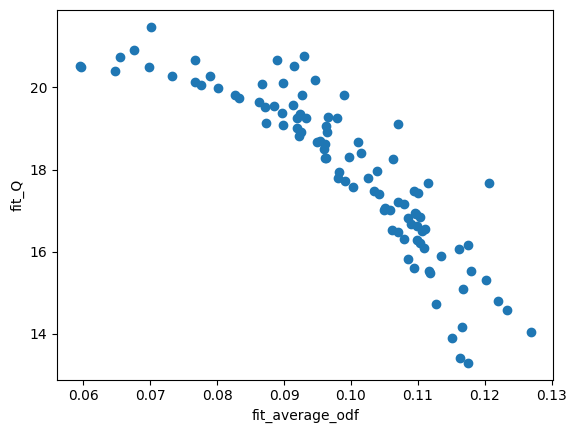

N_GEN = 38
fit1 : [0.1268683152354943, 0.12326647043558474, 0.10700910229378695, 0.07014330917498508, 0.09296593609447096, 0.09469990942379952, 0.12198862996491253, 0.09894970676460468, 0.1207119895338478, 0.11150960126574502, 0.1110100565750246, 0.0915226315667922, 0.106316777587968, 0.0965768154587853, 0.10141738545249093, 0.10944644610402132, 0.11314107174839912, 0.1102624221679149, 0.09275169259352997, 0.10153902659682057, 0.10996468779901854, 0.08892873522633762, 0.09786971615572004, 0.12024498385519086, 0.11756029637056642, 0.06752494873106994, 0.11790028042958889, 0.10384866656347193, 0.1069835282896132, 0.06546091382356135, 0.09127238044562892, 0.10971596941418833, 0.07894135429070943, 0.10103090563180928, 0.09332102360742325, 0.1105912257319178, 0.10991369312834526, 0.1079872132751364, 0.09242769275786074, 0.09648550555262173, 0.11674594340964198, 0.11622530342102871, 0.11085830588106611, 0.10957742621484505, 0.10427302831569804, 0.09631305245379801, 0.08990085608971533, 0.076

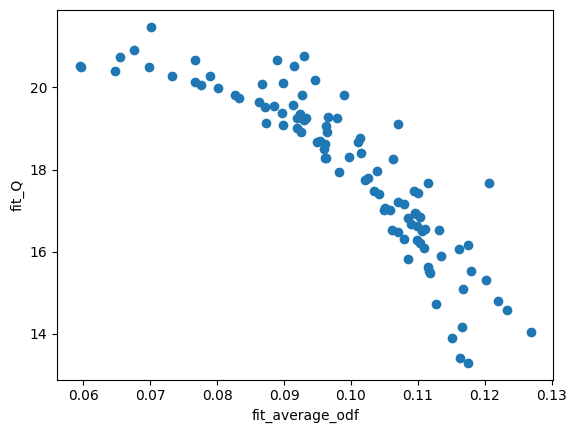

N_GEN = 39
fit1 : [0.1268683152354943, 0.12326647043558474, 0.10700910229378695, 0.07751509877679409, 0.07014330917498508, 0.09296593609447096, 0.09469990942379952, 0.12198862996491253, 0.09894970676460468, 0.1207119895338478, 0.11150960126574502, 0.1110100565750246, 0.0915226315667922, 0.106316777587968, 0.0965768154587853, 0.10141738545249093, 0.10944644610402132, 0.11314107174839912, 0.1102624221679149, 0.09275169259352997, 0.10996468779901854, 0.08892873522633762, 0.10264066763140949, 0.09786971615572004, 0.12024498385519086, 0.11756029637056642, 0.06752494873106994, 0.11790028042958889, 0.10384866656347193, 0.06546091382356135, 0.09127238044562892, 0.10971596941418833, 0.07894135429070943, 0.10103090563180928, 0.09332102360742325, 0.1105912257319178, 0.10991369312834526, 0.09242769275786074, 0.09648550555262173, 0.11674594340964198, 0.11622530342102871, 0.10895230053644184, 0.10153902659682057, 0.11085830588106611, 0.10957742621484505, 0.10427302831569804, 0.09631305245379801, 0.0

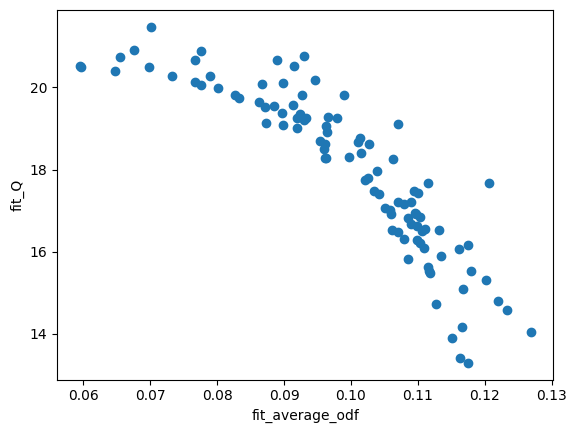

N_GEN = 40
fit1 : [0.1268683152354943, 0.12326647043558474, 0.10700910229378695, 0.07751509877679409, 0.1082323129276508, 0.09613989283290744, 0.07014330917498508, 0.09296593609447096, 0.09469990942379952, 0.12198862996491253, 0.09894970676460468, 0.1207119895338478, 0.07637130830765979, 0.11150960126574502, 0.0915226315667922, 0.106316777587968, 0.11444565970566571, 0.0965768154587853, 0.10864936446990466, 0.10141738545249093, 0.10944644610402132, 0.06806700867918528, 0.09275169259352997, 0.10996468779901854, 0.08892873522633762, 0.10264066763140949, 0.09786971615572004, 0.12024498385519086, 0.11756029637056642, 0.11790028042958889, 0.10384866656347193, 0.1110100565750246, 0.09127238044562892, 0.10971596941418833, 0.07894135429070943, 0.10103090563180928, 0.11314107174839912, 0.09332102360742325, 0.09242769275786074, 0.1102624221679149, 0.09648550555262173, 0.11674594340964198, 0.11622530342102871, 0.10895230053644184, 0.10153902659682057, 0.10957742621484505, 0.10427302831569804, 0.0

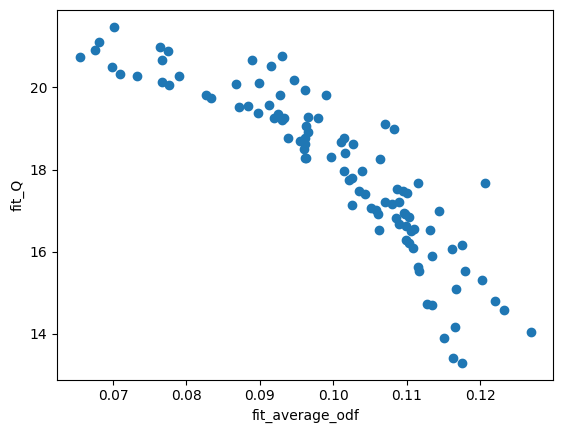

N_GEN = 41
fit1 : [0.1268683152354943, 0.12326647043558474, 0.10700910229378695, 0.07751509877679409, 0.1082323129276508, 0.09613989283290744, 0.07014330917498508, 0.09296593609447096, 0.09469990942379952, 0.12198862996491253, 0.09894970676460468, 0.1207119895338478, 0.07637130830765979, 0.11150960126574502, 0.0915226315667922, 0.106316777587968, 0.11444565970566571, 0.0965768154587853, 0.10864936446990466, 0.10141738545249093, 0.10944644610402132, 0.12036462907067741, 0.06806700867918528, 0.09275169259352997, 0.0729545447668467, 0.10996468779901854, 0.08892873522633762, 0.10264066763140949, 0.09786971615572004, 0.12024498385519086, 0.11756029637056642, 0.11790028042958889, 0.10384866656347193, 0.1110100565750246, 0.09127238044562892, 0.10971596941418833, 0.07894135429070943, 0.10103090563180928, 0.11314107174839912, 0.09332102360742325, 0.09242769275786074, 0.1102624221679149, 0.09648550555262173, 0.11674594340964198, 0.11622530342102871, 0.10895230053644184, 0.10153902659682057, 0.10

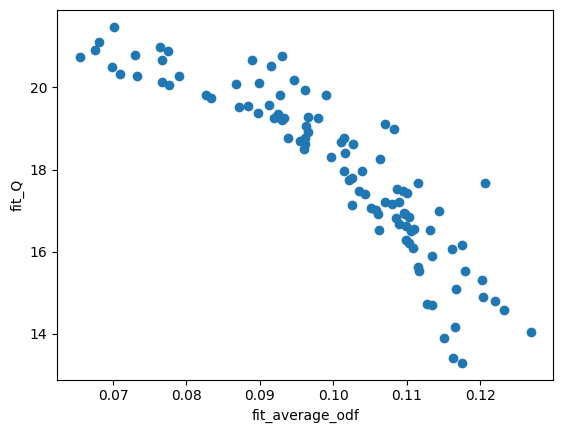

N_GEN = 42
fit1 : [0.1268683152354943, 0.12326647043558474, 0.10700910229378695, 0.12317780527517928, 0.07751509877679409, 0.1082323129276508, 0.09613989283290744, 0.07014330917498508, 0.09296593609447096, 0.09469990942379952, 0.09894970676460468, 0.1207119895338478, 0.07637130830765979, 0.11150960126574502, 0.11604443570652026, 0.0915226315667922, 0.106316777587968, 0.11444565970566571, 0.0965768154587853, 0.10864936446990466, 0.10141738545249093, 0.10944644610402132, 0.11906305467830046, 0.12036462907067741, 0.06806700867918528, 0.09275169259352997, 0.0729545447668467, 0.12198862996491253, 0.10996468779901854, 0.08892873522633762, 0.10264066763140949, 0.09786971615572004, 0.12024498385519086, 0.10384866656347193, 0.1110100565750246, 0.09127238044562892, 0.10971596941418833, 0.07894135429070943, 0.10103090563180928, 0.11314107174839912, 0.09332102360742325, 0.09242769275786074, 0.1102624221679149, 0.09648550555262173, 0.10895230053644184, 0.10527505806364665, 0.10153902659682057, 0.10

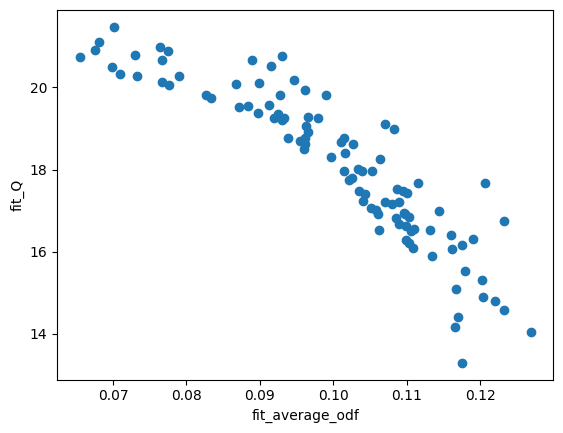

N_GEN = 43
fit1 : [0.1268683152354943, 0.12326647043558474, 0.10700910229378695, 0.12317780527517928, 0.1082323129276508, 0.09613989283290744, 0.07014330917498508, 0.09296593609447096, 0.09469990942379952, 0.09894970676460468, 0.1207119895338478, 0.08777645097423467, 0.11150960126574502, 0.11604443570652026, 0.0915226315667922, 0.106316777587968, 0.11444565970566571, 0.07751509877679409, 0.10864936446990466, 0.10141738545249093, 0.10944644610402132, 0.11906305467830046, 0.12036462907067741, 0.06806700867918528, 0.09275169259352997, 0.09805700710474533, 0.12198862996491253, 0.10996468779901854, 0.08892873522633762, 0.10264066763140949, 0.07637130830765979, 0.12024498385519086, 0.12403310414218867, 0.10384866656347193, 0.1110100565750246, 0.09127238044562892, 0.10971596941418833, 0.0965768154587853, 0.07894135429070943, 0.12185889597943883, 0.10103090563180928, 0.11314107174839912, 0.09242769275786074, 0.1102624221679149, 0.0729545447668467, 0.10895230053644184, 0.10527505806364665, 0.10

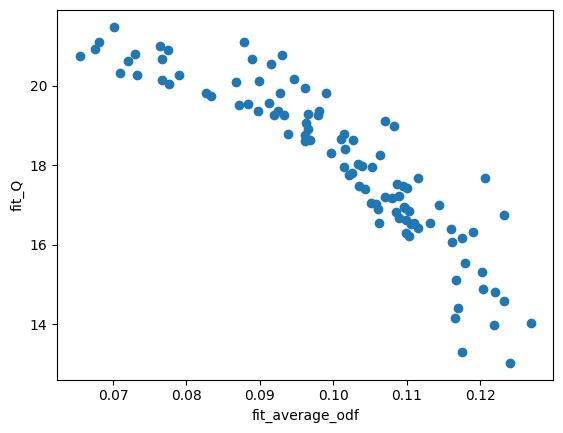

N_GEN = 44
fit1 : [0.1268683152354943, 0.12326647043558474, 0.10700910229378695, 0.12317780527517928, 0.1082323129276508, 0.09613989283290744, 0.07014330917498508, 0.09296593609447096, 0.09469990942379952, 0.09894970676460468, 0.09447765774305379, 0.1207119895338478, 0.08777645097423467, 0.11150960126574502, 0.11604443570652026, 0.0915226315667922, 0.106316777587968, 0.11444565970566571, 0.07751509877679409, 0.10864936446990466, 0.10141738545249093, 0.10944644610402132, 0.11906305467830046, 0.12036462907067741, 0.06806700867918528, 0.09275169259352997, 0.09805700710474533, 0.12198862996491253, 0.10996468779901854, 0.08892873522633762, 0.10264066763140949, 0.07637130830765979, 0.12024498385519086, 0.11502785644368846, 0.12403310414218867, 0.10384866656347193, 0.1110100565750246, 0.09127238044562892, 0.10971596941418833, 0.0965768154587853, 0.12185889597943883, 0.10103090563180928, 0.11314107174839912, 0.09242769275786074, 0.1102624221679149, 0.0729545447668467, 0.10895230053644184, 0.10

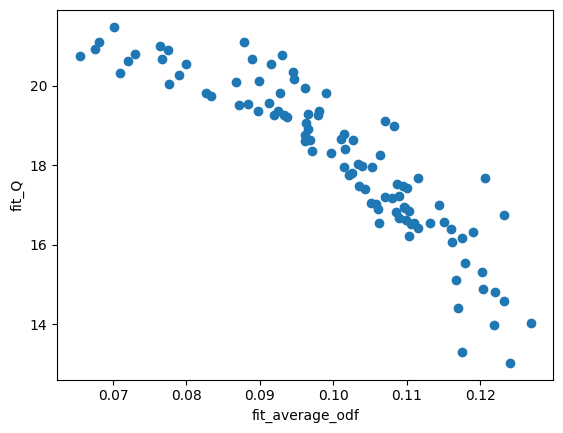

N_GEN = 45
fit1 : [0.1268683152354943, 0.12326647043558474, 0.06888573839027808, 0.10700910229378695, 0.12317780527517928, 0.1082323129276508, 0.09613989283290744, 0.07014330917498508, 0.09296593609447096, 0.09469990942379952, 0.09894970676460468, 0.09447765774305379, 0.1207119895338478, 0.08777645097423467, 0.11150960126574502, 0.11604443570652026, 0.0915226315667922, 0.106316777587968, 0.11444565970566571, 0.07751509877679409, 0.10864936446990466, 0.10141738545249093, 0.10944644610402132, 0.11906305467830046, 0.12036462907067741, 0.06806700867918528, 0.09275169259352997, 0.09805700710474533, 0.12198862996491253, 0.10996468779901854, 0.08892873522633762, 0.10264066763140949, 0.07637130830765979, 0.12024498385519086, 0.09522121413140544, 0.11502785644368846, 0.12403310414218867, 0.10384866656347193, 0.1110100565750246, 0.09127238044562892, 0.10971596941418833, 0.0965768154587853, 0.08551924743653605, 0.08112607621230143, 0.12185889597943883, 0.10103090563180928, 0.11314107174839912, 0.

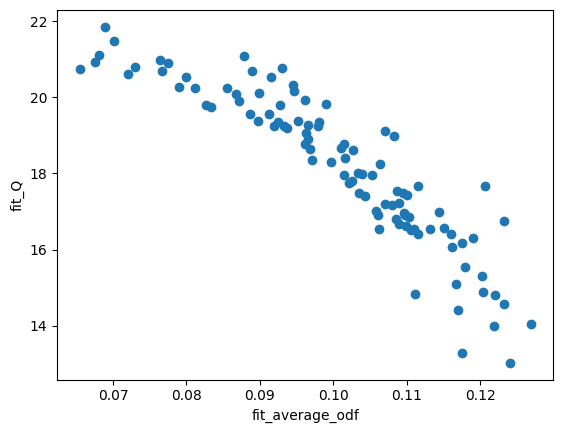

N_GEN = 46
fit1 : [0.1268683152354943, 0.07755905025679492, 0.12326647043558474, 0.06888573839027808, 0.10700910229378695, 0.12317780527517928, 0.1082323129276508, 0.09613989283290744, 0.09296593609447096, 0.09469990942379952, 0.09447765774305379, 0.10010719822643079, 0.1207119895338478, 0.08777645097423467, 0.11150960126574502, 0.11604443570652026, 0.0915226315667922, 0.106316777587968, 0.11444565970566571, 0.07751509877679409, 0.10864936446990466, 0.10141738545249093, 0.10944644610402132, 0.11906305467830046, 0.12036462907067741, 0.07014330917498508, 0.12198862996491253, 0.10725717735883833, 0.10996468779901854, 0.08892873522633762, 0.10264066763140949, 0.09894970676460468, 0.07637130830765979, 0.12024498385519086, 0.11502785644368846, 0.09237882532330272, 0.12403310414218867, 0.10384866656347193, 0.1110100565750246, 0.10971596941418833, 0.10361409907367361, 0.08551924743653605, 0.08112607621230143, 0.12185889597943883, 0.10103090563180928, 0.11314107174839912, 0.06806700867918528, 0

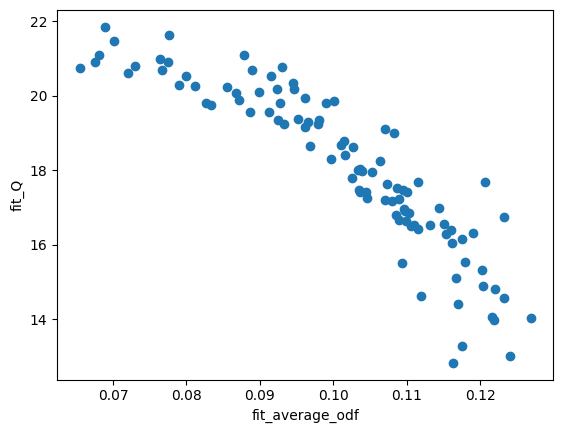

N_GEN = 47
fit1 : [0.1268683152354943, 0.07755905025679492, 0.12326647043558474, 0.06888573839027808, 0.10700910229378695, 0.12317780527517928, 0.1082323129276508, 0.09613989283290744, 0.09296593609447096, 0.09469990942379952, 0.09447765774305379, 0.10010719822643079, 0.1207119895338478, 0.08777645097423467, 0.11150960126574502, 0.09253518441278391, 0.11604443570652026, 0.0915226315667922, 0.106316777587968, 0.11444565970566571, 0.07751509877679409, 0.10864936446990466, 0.10141738545249093, 0.10944644610402132, 0.11906305467830046, 0.12036462907067741, 0.07321966002534544, 0.07014330917498508, 0.12198862996491253, 0.10725717735883833, 0.09152697929453585, 0.10996468779901854, 0.08892873522633762, 0.10264066763140949, 0.09894970676460468, 0.07637130830765979, 0.12024498385519086, 0.11502785644368846, 0.09237882532330272, 0.12403310414218867, 0.1110100565750246, 0.10971596941418833, 0.08551924743653605, 0.08112607621230143, 0.12185889597943883, 0.10103090563180928, 0.11314107174839912, 0

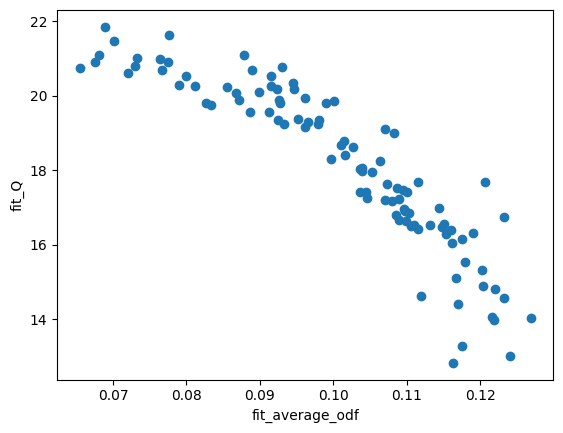

N_GEN = 48
fit1 : [0.1268683152354943, 0.07755905025679492, 0.12326647043558474, 0.06888573839027808, 0.10700910229378695, 0.12317780527517928, 0.1082323129276508, 0.09613989283290744, 0.09296593609447096, 0.09469990942379952, 0.09447765774305379, 0.10010719822643079, 0.1207119895338478, 0.08777645097423467, 0.11150960126574502, 0.11604443570652026, 0.0915226315667922, 0.106316777587968, 0.11444565970566571, 0.07751509877679409, 0.10864936446990466, 0.10141738545249093, 0.10944644610402132, 0.11906305467830046, 0.12036462907067741, 0.09279293927672151, 0.07321966002534544, 0.07014330917498508, 0.12198862996491253, 0.10725717735883833, 0.10996468779901854, 0.08892873522633762, 0.10264066763140949, 0.09894970676460468, 0.07637130830765979, 0.12024498385519086, 0.11502785644368846, 0.12403310414218867, 0.09253518441278391, 0.1110100565750246, 0.10971596941418833, 0.12185889597943883, 0.10103090563180928, 0.11314107174839912, 0.06806700867918528, 0.1102624221679149, 0.09275169259352997, 0.

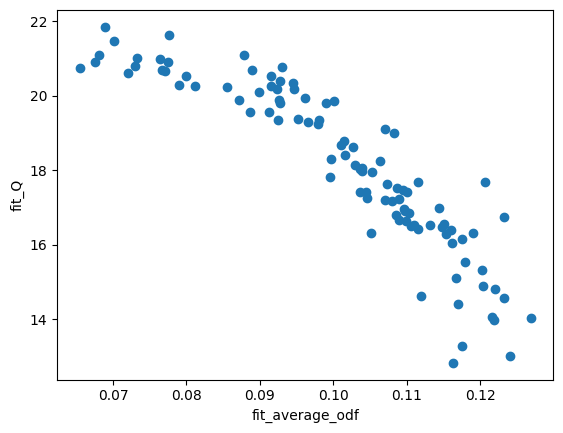

N_GEN = 49
fit1 : [0.1268683152354943, 0.07755905025679492, 0.12326647043558474, 0.06888573839027808, 0.10700910229378695, 0.12317780527517928, 0.1082323129276508, 0.09613989283290744, 0.09296593609447096, 0.09469990942379952, 0.09447765774305379, 0.10010719822643079, 0.1207119895338478, 0.08777645097423467, 0.11150960126574502, 0.11604443570652026, 0.0915226315667922, 0.106316777587968, 0.11444565970566571, 0.07751509877679409, 0.10864936446990466, 0.10141738545249093, 0.10944644610402132, 0.09279293927672151, 0.07321966002534544, 0.07014330917498508, 0.10725717735883833, 0.10996468779901854, 0.08892873522633762, 0.10264066763140949, 0.12226445399310863, 0.09894970676460468, 0.07637130830765979, 0.1109873061422237, 0.11502785644368846, 0.12403310414218867, 0.09253518441278391, 0.1110100565750246, 0.10971596941418833, 0.10103090563180928, 0.11906305467830046, 0.11314107174839912, 0.12036462907067741, 0.06806700867918528, 0.1102624221679149, 0.09275169259352997, 0.09805700710474533, 0.0

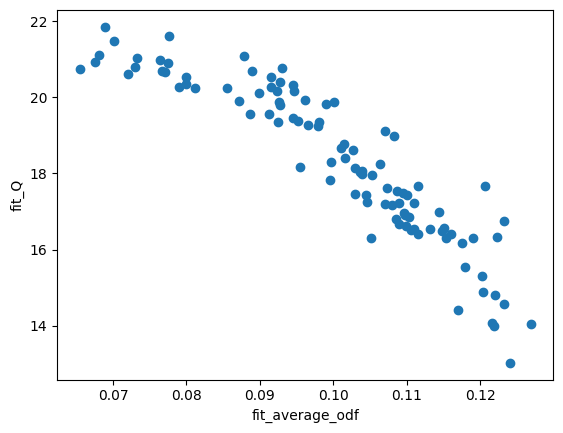

[['75780',
  '500865',
  '299055',
  '152407',
  '19509',
  '342330',
  '394886',
  '538129',
  '401449',
  '154202',
  '176184',
  '542899',
  '83906',
  '460073',
  '9762',
  '542319',
  '546890',
  '546891',
  '306636',
  '475666',
  '117287',
  '276567',
  '52064',
  '491667',
  '52064',
  '230262',
  '279830',
  '30690',
  '347716',
  '538129',
  '186827',
  '434830',
  '521655',
  '491667',
  '60211',
  '377247',
  '521655',
  '120615',
  '500861',
  '51175',
  '542780',
  '294393',
  '546890',
  '181025',
  '352553',
  '280255',
  '462210',
  '142115',
  '435398',
  '219603',
  '511063',
  '59912',
  '238665',
  '401798',
  '35067',
  '335183',
  '49424',
  '28513',
  '366824',
  '542633',
  '127262',
  '30962',
  '350442',
  '123953',
  '52500',
  '150207',
  '279830',
  '525489',
  '504412',
  '150207',
  '30093',
  '79870',
  '373799',
  '321818',
  '480479',
  '366824',
  '480479',
  '396502',
  '237111',
  '339225',
  '300975',
  '330328',
  '270524',
  '114378',
  '230788'

In [16]:
evolved_pop, fitness = evolve(pop, fit_average_odf, fit_Q, amazon_G, conversiones, T=10, n_gen=50, fit1_maximize=False, fit2_maximize=True, pcross=0.8, pmut=0.2)
evolved_pop

long 100
fit1 : [7.882188694088848, 12.893401823272512, 8.112506153976742, 14.516792929292931, 9.344999430458357, 8.118345652885125, 9.23938492063492, 10.4015094101301, 10.756628094128095, 10.559672190554544, 10.584513035983626, 9.989291656411222, 8.284181247029546, 11.39257726750374, 8.967837644811327, 8.61738862272918, 10.926259252729842, 9.405853174603173, 8.73777129303445, 12.900712451799407, 9.203919460257222, 9.860242359120067, 9.136888730389876, 10.776682016813595, 13.657534050916404, 14.256527269027272, 9.323385386543283, 9.093828391680558, 11.244959207459207, 9.742726962579907, 8.178992072742075, 10.106144148249413, 13.093922601978868, 9.01003938871586, 8.693546336561042, 8.062363728647957, 10.806700244200243, 9.008192868661975, 9.114443460950815, 9.897961358816623, 8.398911002997693, 8.838523310195136, 8.30808857808858, 14.691405122655123, 9.069272924787628, 10.781474407944996, 10.198149316570369, 13.707165238143498, 9.178328452593156, 8.197485292485293, 9.498926131058486, 12

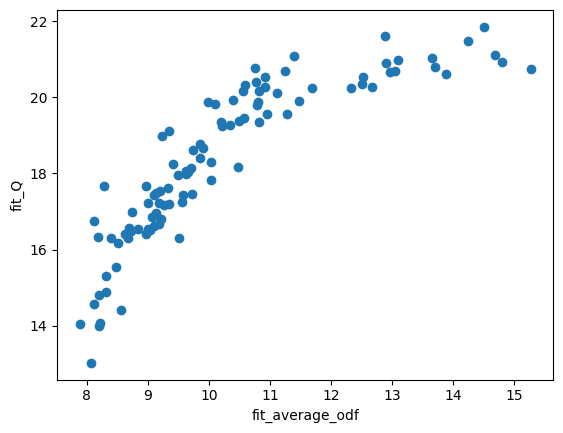

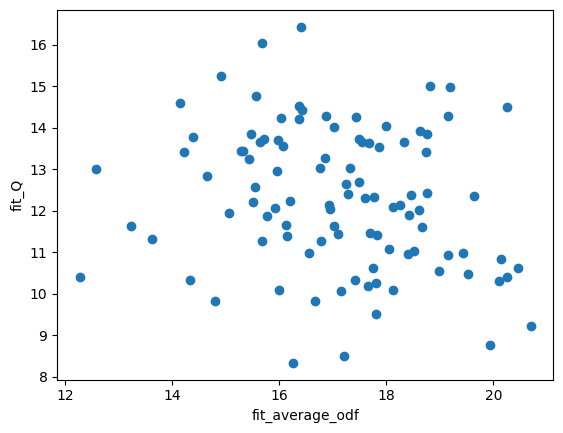

In [17]:
import matplotlib.pyplot as plt

# pop = create(amazon_G.nodes, A, conversiones)

print(f"long {len(evolved_pop)}")
fits1 = []
fits2 = []

for ind in evolved_pop:
    fits1.append(fit_average_odf(amazon_G, ind, conversiones))
    fits2.append(fit_Q(amazon_G, ind, conversiones))

print(f"fit1 : {fits1}")
print(f"fit2 : {fits2}")

plt.scatter(fits1, fits2)
plt.xlabel('fit_average_odf')
plt.ylabel('fit_Q')

plt.show()

fits1 = []
fits2 = []

for ind in pop:
    fits1.append(fit_average_odf(amazon_G, ind, conversiones))
    fits2.append(fit_Q(amazon_G, ind, conversiones))

plt.scatter(fits1, fits2)
plt.xlabel('fit_average_odf')
plt.ylabel('fit_Q')

plt.show()


In [18]:
get_comunidades(evolved_pop[0])

[{0, '75780'},
 {1, 237, 272, 294, '500865'},
 {147, 2, '299055'},
 {'152407', 169, 3},
 {168, '19509', 201, 4, 94},
 {'342330', 5, 86},
 {204, 242, '394886', 410, 6},
 {29, '538129', 7},
 {381, 395, '401449', 8},
 {'154202', 9},
 {10, '176184'},
 {11, '542899'},
 {12, 278, 423, '83906'},
 {13, 321, '460073'},
 {14, '9762'},
 {15, 370, 384, '542319'},
 {16, 42, '546890'},
 {17, '546891'},
 {18, 187, '306636', 355, 363},
 {19, 411, '475666'},
 {'117287', 20},
 {21, '276567', 435},
 {22, 24, 248, 413, '52064'},
 {23, 33, '491667'},
 {'230262', 25},
 {167, 26, '279830', 358, 374, 443, 66},
 {106, 109, 27, 296, '30690', 414},
 {28, '347716'},
 {122, '186827', 30},
 {155, 31, '434830'},
 {32, 326, 345, 36, 394, 447, 468, '521655', 99},
 {34, '60211'},
 {35, '377247'},
 {119, '120615', 37, 466},
 {295, 339, 38, '500861'},
 {39, '51175'},
 {386, 40, '542780'},
 {124, 133, '294393', 303, 376, 41},
 {'181025', 43},
 {313, '352553', 44},
 {'280255', 298, 372, 382, 425, 45},
 {341, 46, '462210', 